# DivPs analysis Formenti Demaria Blosum 45 distance metric 50000 random samples random frequences


TCRDivER analysis of the Murine dataset with Blosum45 distance used as TCR distance metric with sample frequencies randomised.

**Instructions** 

Set path to working directory which should contain: 

* divP_tsv directory: containting all the diversities calculated at varying $q$ and $\lambda$s the TCRDivER algorithm outputs
* filtered directory: containing all the filetered TCR repertoires the TCRDivER algorithm outputs


In [1]:
from os import listdir
from os.path import isfile, join
import os
import re
import pandas as pd
from collections import defaultdict
from collections import OrderedDict
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import decomposition
from sklearn.metrics import accuracy_score

In [2]:
def plt_divP(divP_df, sample_name, time, treatment, patient, wdir_path): 
    divP_df_long = pd.melt(divP_df, "q", var_name = "Lambda", value_name = "DqZ")
    qs_label = [q if q != "7" else "$\infty$" for q in list(map(str, divP_df["q"]))]
    plt.figure(figsize=(6,8))
    sns.color_palette("colorblind")
    ax =sns.lineplot(x="q", y="DqZ", data=divP_df_long, hue = "Lambda", markers=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.fill_between(divP_df["q"].values, divP_df["16.0"].values, divP_df["identity"].values, 
                 facecolor='red', alpha = 0.2)
    
    plt.xticks(ticks = divP_df["q"].values, labels = qs_label, fontsize = 13)
    plt.yticks(ticks = range(0,13), fontsize = 13)
    plt.ylim(top=12)
    plt.xlabel("q", fontsize = 20)
    plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
    plt.title(patient, fontsize = 20)
    if not os.path.isdir(wdir_path+"divPs/"):
        os.makedirs(wdir_path+"divPs/", exist_ok=False)
    plt.savefig(wdir_path + "divPs/"+ sample_name + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
    return plt

In [3]:
def calculate_area_between_curves(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas.reverse()
    area_dict = OrderedDict()
    for index,first in list(enumerate(lambdas)):
        for second in lambdas[index+1:]:
            area = np.trapz(divP_df[first].values , x=divP_df["q"].values) - np.trapz(divP_df[second].values , x=divP_df["q"].values)
            area_dict["_".join([first, second, "area"])] = area
    return area_dict



In [4]:
def calculate_slopes(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas = [lb for lb in lambdas if lb != "0.0"]
    lambdas.reverse()
    slope_dict = OrderedDict()
    for lb in lambdas: 
        slope_dict["_".join(["0_1_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[1, lb]
        slope_dict["_".join(["0_2_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[2, lb]
        slope_dict["_".join(["1_2_slope", lb])] = divP_df.loc[1, lb]-divP_df.loc[2, lb]
    return slope_dict

In [5]:
def calculate_avg_delta_lambda_05_00(divP_df):
    avg_delta_lambda = divP_df[["0.0","0.1","0.2", "0.3", "0.4", "0.5"]].diff(axis = 1).mean().mean()
    return avg_delta_lambda

In [6]:
def make_divP_one_row_df(divP_df):
    divP_df_wo_L0 = divP_df.drop("0.0", axis = 1)
    list_of_lambdas = [lmbd for lmbd in list(divP_df_wo_L0) if lmbd != "q"]
    list_of_dqz = list()
    for lmbd in list_of_lambdas:
        for qu in divP_df_wo_L0["q"]:
            if qu == 7: 
                qu = 11
                qu_name = "infinity"
            qu_name = str(qu)
            list_of_dqz.append(("L_"+ lmbd + "_q_" +qu_name, divP_df_wo_L0.loc[qu,lmbd]))
    sample_dqz = pd.DataFrame(list_of_dqz).T
    sample_dqz.columns = sample_dqz.iloc[0]
    sample_dqz = sample_dqz.drop(sample_dqz.index[0])
    sample_dqz = sample_dqz.reset_index(drop = "True")
    return sample_dqz



In [7]:
# Set path to working directory:
wdir_path = "/Users/milvu/Documents/OneDrive - Danmarks Tekniske Universitet/TCR_analysis/TCRDivER_algorithm/datasets_divP_calculated/2018_Formenti_Demaria_Lung_50000_random_freqs/"


Let's make the metadata dataframe from the filenames themselves by establishing some criteria. 

In [8]:
#read in filtered filenames and count unique CDR3s
filtered_fpath = wdir_path + "filtered/"
files = [f for f in listdir(filtered_fpath) if isfile(join(filtered_fpath, f))]
files = [f for f in listdir(filtered_fpath) if f.endswith(".tsv")]
unique_CDR3s_dict = defaultdict()
for file in files: 
    num_lines = sum(1 for line in open(filtered_fpath+file))
    unique_CDR3s_dict["_".join(file.split("_")[:-1])]=num_lines

print(files)


# Read in metadata: 
mddf_list = list()

for k,v in unique_CDR3s_dict.items():
    mddf_list.append([k] + k.split("_") + [v])
    

mddf = pd.DataFrame(mddf_list, columns = ["sample_name", "patient", "RECIST", "sample_type", "timepoint", "unique_CDR3s"])
mddf

['Pt43_PD_PBMC_Day22_filtered.tsv', 'Pt22_SD_PBMC_Day22_filtered.tsv', 'Pt43_PD_PBMC_Day0_filtered.tsv', 'Pt5_SD_PBMC_Day0_filtered.tsv', 'Pt1_PR_PBMC_Day0_filtered.tsv', 'Pt36_PD_PBMC_Day22_filtered.tsv', 'Pt36_PD_PBMC_Day0_filtered.tsv', 'Pt44_PR_PBMC_Day22_filtered.tsv', 'Pt27_PD_PBMC_Day22_filtered.tsv', 'Pt37_PR_PBMC_Day0_filtered.tsv', 'Pt10_PD_PBMC_Day0_filtered.tsv', 'Pt32_SD_PBMC_Day22_filtered.tsv', 'Pt37_PR_PBMC_Day22_filtered.tsv', 'Pt23_PR_PBMC_Day0_filtered.tsv', 'Pt4_CR_PBMC_Day0_filtered.tsv', 'Pt32_SD_PBMC_Day0_filtered.tsv', 'Pt40_PD_PBMC_Day0_filtered.tsv', 'Pt38_PD_PBMC_Day22_filtered.tsv', 'Pt17_PR_PBMC_Day0_filtered.tsv', 'Pt1_PR_PBMC_Day22_filtered.tsv', 'Pt10_PD_PBMC_Day22_filtered.tsv', 'Pt16_PD_PBMC_Day0_filtered.tsv', 'Pt3_CR_PBMC_Day0_filtered.tsv', 'Pt38_PD_PBMC_Day0_filtered.tsv', 'Pt30_SD_PBMC_Day22_filtered.tsv', 'Pt9_SD_PBMC_Day0_filtered.tsv', 'Pt40_PD_PBMC_Day22_filtered.tsv', 'Pt23_PR_PBMC_Day22_filtered.tsv', 'Pt4_CR_PBMC_Day22_filtered.tsv', 'Pt28_

sample_name patient RECIST sample_type timepoint  unique_CDR3s
0   Pt43_PD_PBMC_Day22    Pt43     PD        PBMC     Day22         32983
1   Pt22_SD_PBMC_Day22    Pt22     SD        PBMC     Day22         30146
2    Pt43_PD_PBMC_Day0    Pt43     PD        PBMC      Day0         32998
3     Pt5_SD_PBMC_Day0     Pt5     SD        PBMC      Day0         36074
4     Pt1_PR_PBMC_Day0     Pt1     PR        PBMC      Day0         33446
5   Pt36_PD_PBMC_Day22    Pt36     PD        PBMC     Day22         22467
6    Pt36_PD_PBMC_Day0    Pt36     PD        PBMC      Day0         21211
7   Pt44_PR_PBMC_Day22    Pt44     PR        PBMC     Day22         28538
8   Pt27_PD_PBMC_Day22    Pt27     PD        PBMC     Day22         17699
9    Pt37_PR_PBMC_Day0    Pt37     PR        PBMC      Day0         33824
10   Pt10_PD_PBMC_Day0    Pt10     PD        PBMC      Day0         39555
11  Pt32_SD_PBMC_Day22    Pt32     SD        PBMC     Day22         19849
12  Pt37_PR_PBMC_Day22    Pt37     PR        PBMC     Day22         35062
13   Pt23_PR_PBMC_Day0    Pt23     PR        PBMC      Day0         16753
14    Pt4_CR_PBMC_Day0     Pt4     CR        PBMC      Day0         27209
15   Pt32_SD_PBMC_Day0    Pt32     SD        PBMC      Day0         18287
16   Pt40_PD_PBMC_Day0    Pt40     PD        PBMC      Day0         20905
17  Pt38_PD_PBMC_Day22    Pt38     PD        PBMC     Day22         20022
18   Pt17_PR_PBMC_Day0    Pt17     PR        PBMC      Day0         37698
19   Pt1_PR_PBMC_Day22     Pt1     PR        PBMC     Day22         33568
20  Pt10_PD_PBMC_Day22    Pt10     PD        PBMC     Day22         39417
21   Pt16_PD_PBMC_Day0    Pt16     PD        PBMC      Day0         36110
22    Pt3_CR_PBMC_Day0     Pt3     CR        PBMC      Day0         29075
23   Pt38_PD_PBMC_Day0    Pt38     PD        PBMC      Day0         18942
24  Pt30_SD_PBMC_Day22    Pt30     SD        PBMC     Day22         20291
25    Pt9_SD_PBMC_Day0     Pt9     SD        PBMC      Day0         21371
26  Pt40_PD_PBMC_Day22    Pt40     PD        PBMC     Day22         26737
27  Pt23_PR_PBMC_Day22    Pt23     PR        PBMC     Day22         17549
28   Pt4_CR_PBMC_Day22     Pt4     CR        PBMC     Day22         29732
29  Pt28_PD_PBMC_Day22    Pt28     PD        PBMC     Day22         36018
30   Pt28_PD_PBMC_Day0    Pt28     PD        PBMC      Day0         38151
31   Pt9_SD_PBMC_Day22     Pt9     SD        PBMC     Day22         20669
32   Pt5_SD_PBMC_Day22     Pt5     SD        PBMC     Day22         36579
33   Pt30_SD_PBMC_Day0    Pt30     SD        PBMC      Day0         17423
34  Pt17_PR_PBMC_Day22    Pt17     PR        PBMC     Day22         32628
35   Pt44_PR_PBMC_Day0    Pt44     PR        PBMC      Day0         29786
36   Pt22_SD_PBMC_Day0    Pt22     SD        PBMC      Day0         26421
37  Pt16_PD_PBMC_Day22    Pt16     PD        PBMC     Day22         35294
38   Pt3_CR_PBMC_Day22     Pt3     CR        PBMC     Day22         27116
39   Pt27_PD_PBMC_Day0    Pt27     PD        PBMC      Day0         25848

## Plot Diversity Profiles for individual samples 

In [9]:
# load filenames: 
divP_fpath = wdir_path + "divP_tsv/"
divP_files = [f for f in listdir(divP_fpath) if isfile(join(divP_fpath, f))]
divP_files = [f for f in divP_files if f.endswith('tsv')]
divP_files = [re.sub('\.tsv$', '', f) for f in divP_files]
divP_files.sort()
divP_files = [f for f in divP_files]

divP_files

['Pt10_PD_PBMC_Day0_divP',
 'Pt10_PD_PBMC_Day22_divP',
 'Pt16_PD_PBMC_Day0_divP',
 'Pt16_PD_PBMC_Day22_divP',
 'Pt17_PR_PBMC_Day0_divP',
 'Pt17_PR_PBMC_Day22_divP',
 'Pt1_PR_PBMC_Day0_divP',
 'Pt1_PR_PBMC_Day22_divP',
 'Pt22_SD_PBMC_Day0_divP',
 'Pt22_SD_PBMC_Day22_divP',
 'Pt23_PR_PBMC_Day0_divP',
 'Pt23_PR_PBMC_Day22_divP',
 'Pt27_PD_PBMC_Day0_divP',
 'Pt27_PD_PBMC_Day22_divP',
 'Pt28_PD_PBMC_Day0_divP',
 'Pt28_PD_PBMC_Day22_divP',
 'Pt30_SD_PBMC_Day0_divP',
 'Pt30_SD_PBMC_Day22_divP',
 'Pt32_SD_PBMC_Day0_divP',
 'Pt32_SD_PBMC_Day22_divP',
 'Pt36_PD_PBMC_Day0_divP',
 'Pt36_PD_PBMC_Day22_divP',
 'Pt37_PR_PBMC_Day0_divP',
 'Pt37_PR_PBMC_Day22_divP',
 'Pt38_PD_PBMC_Day0_divP',
 'Pt38_PD_PBMC_Day22_divP',
 'Pt3_CR_PBMC_Day0_divP',
 'Pt3_CR_PBMC_Day22_divP',
 'Pt40_PD_PBMC_Day0_divP',
 'Pt40_PD_PBMC_Day22_divP',
 'Pt43_PD_PBMC_Day0_divP',
 'Pt43_PD_PBMC_Day22_divP',
 'Pt44_PR_PBMC_Day0_divP',
 'Pt44_PR_PBMC_Day22_divP',
 'Pt4_CR_PBMC_Day0_divP',
 'Pt4_CR_PBMC_Day22_divP',
 'Pt5_SD_PBMC_Da

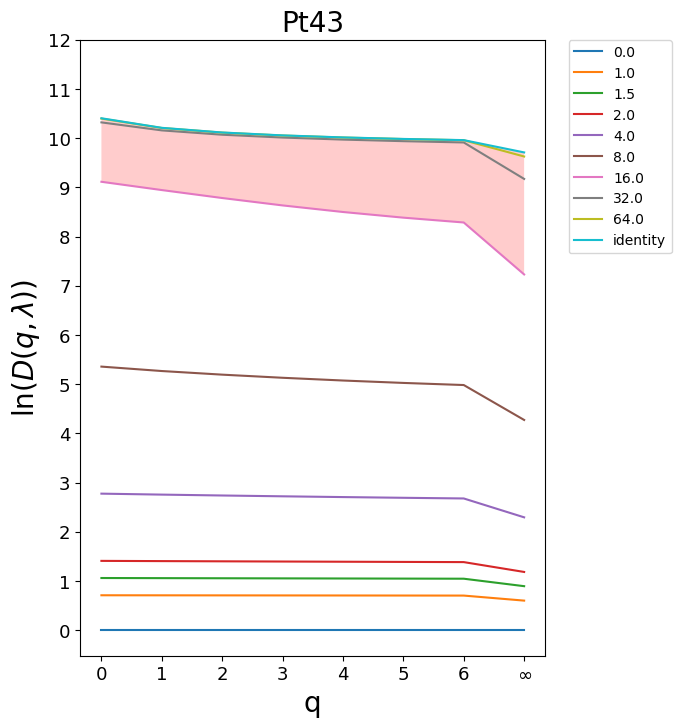

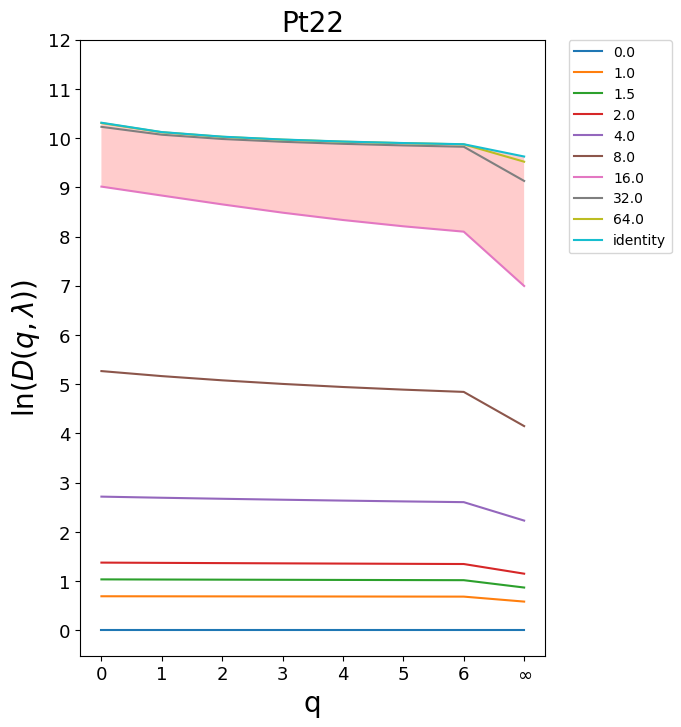

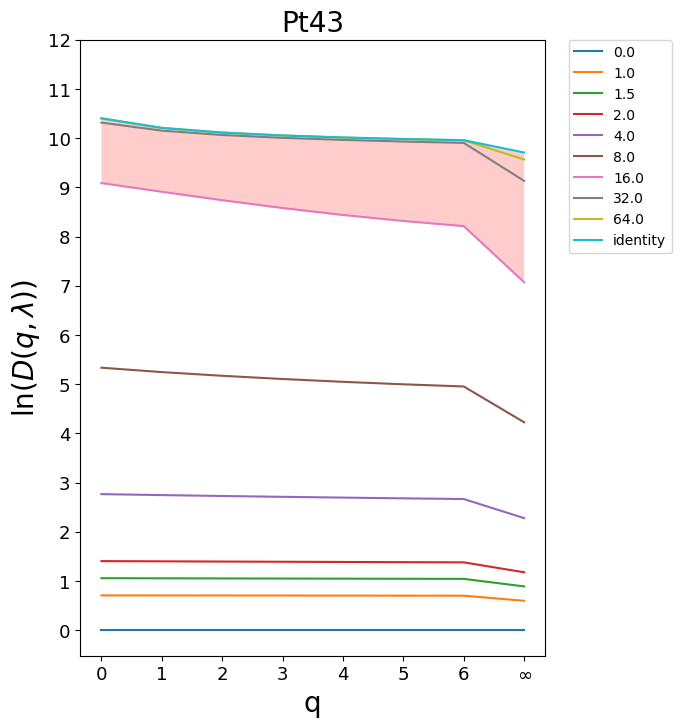

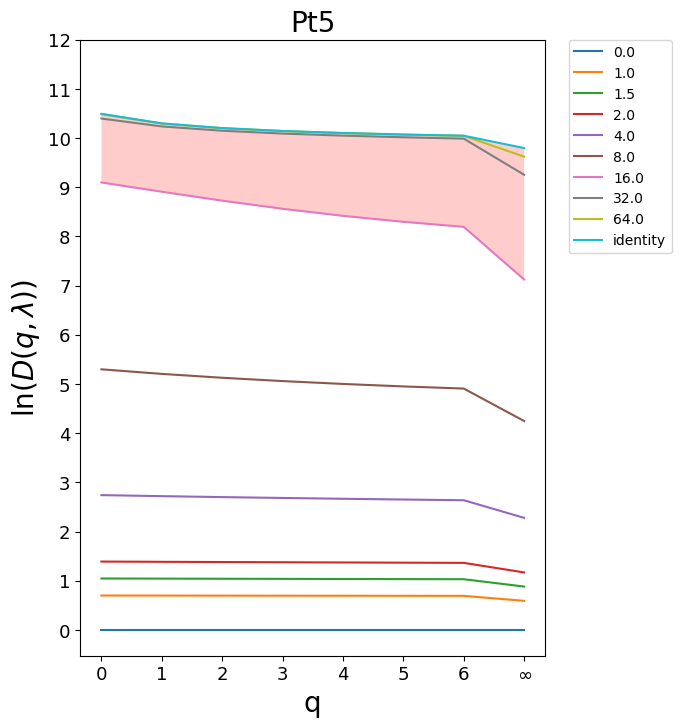

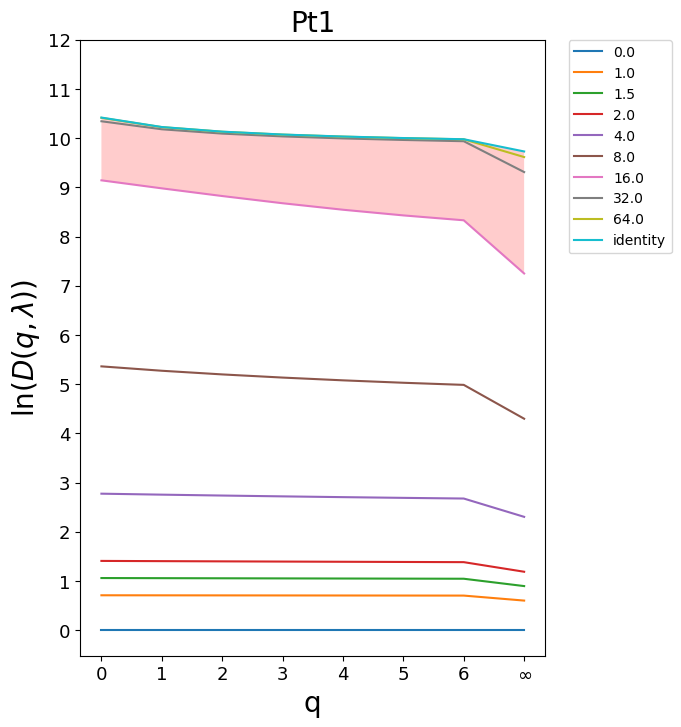

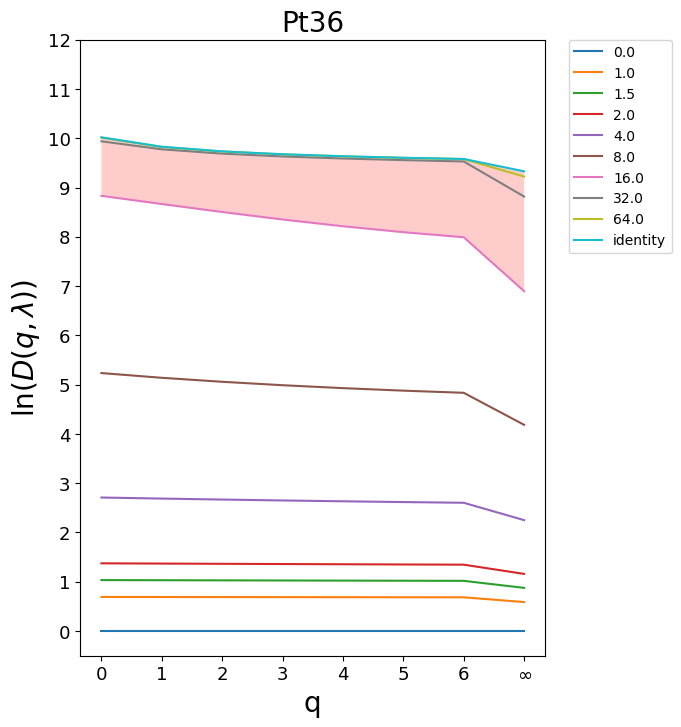

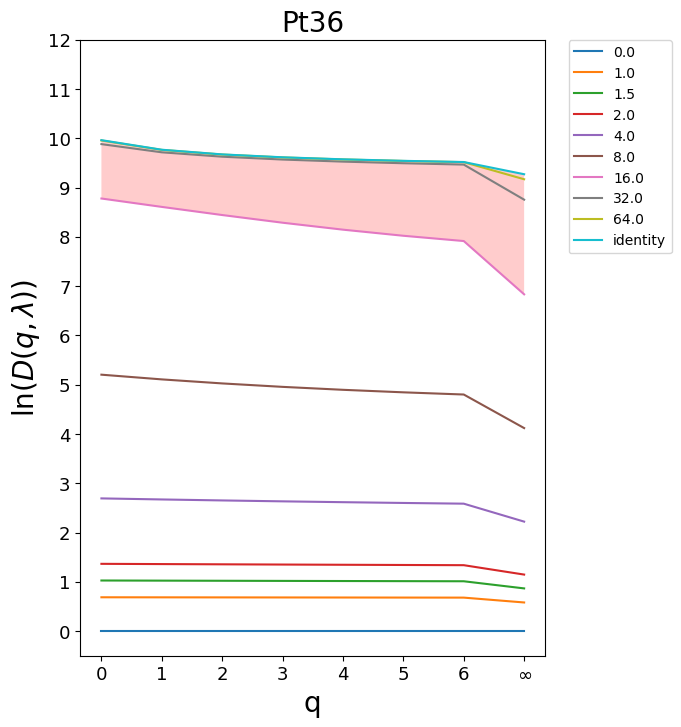

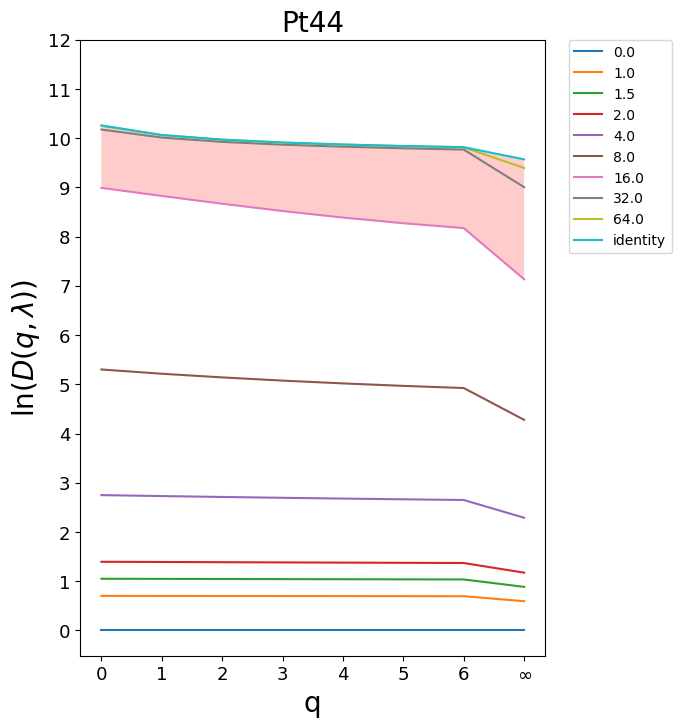

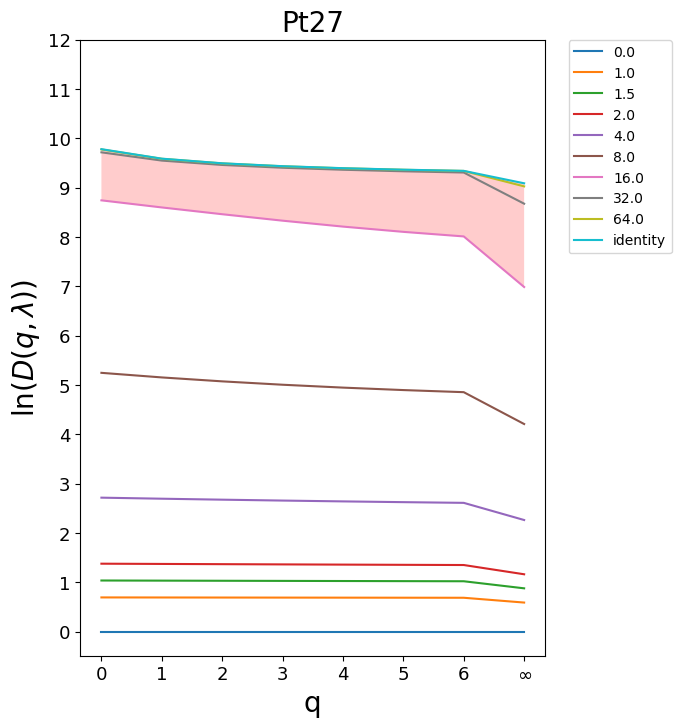

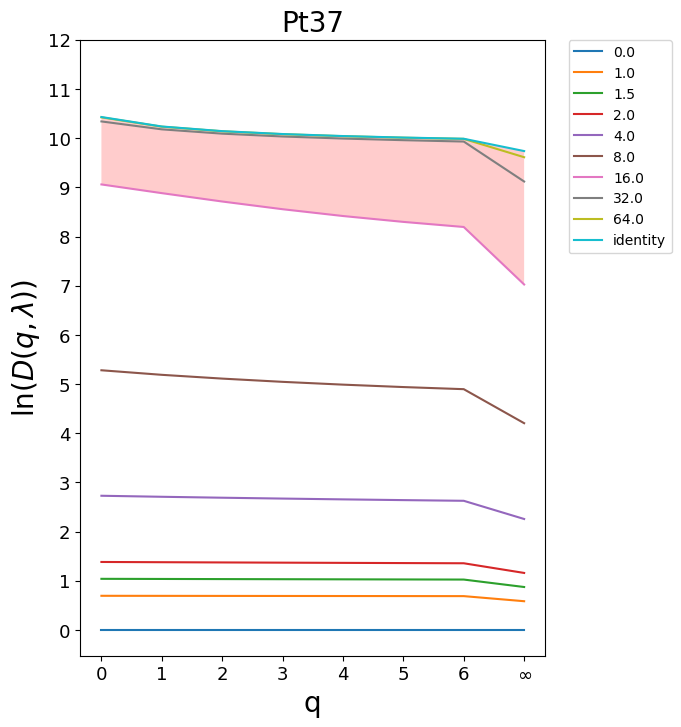

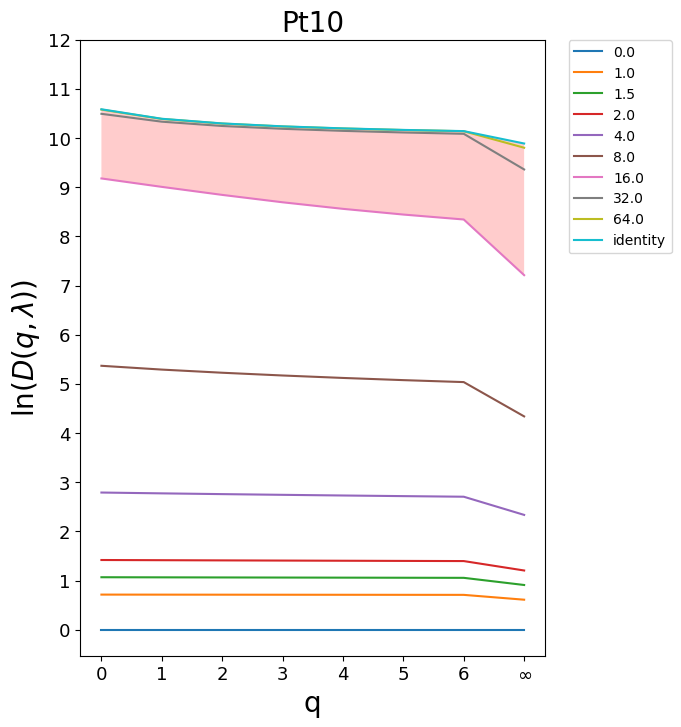

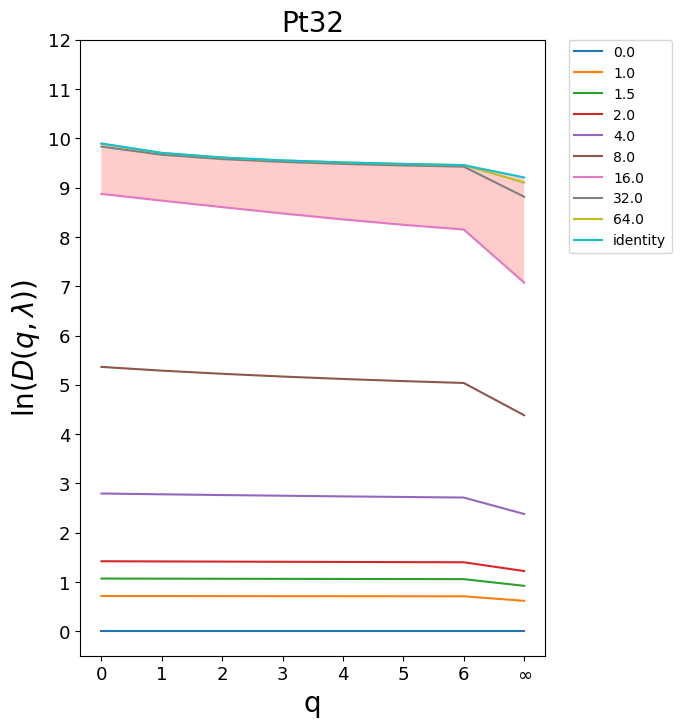

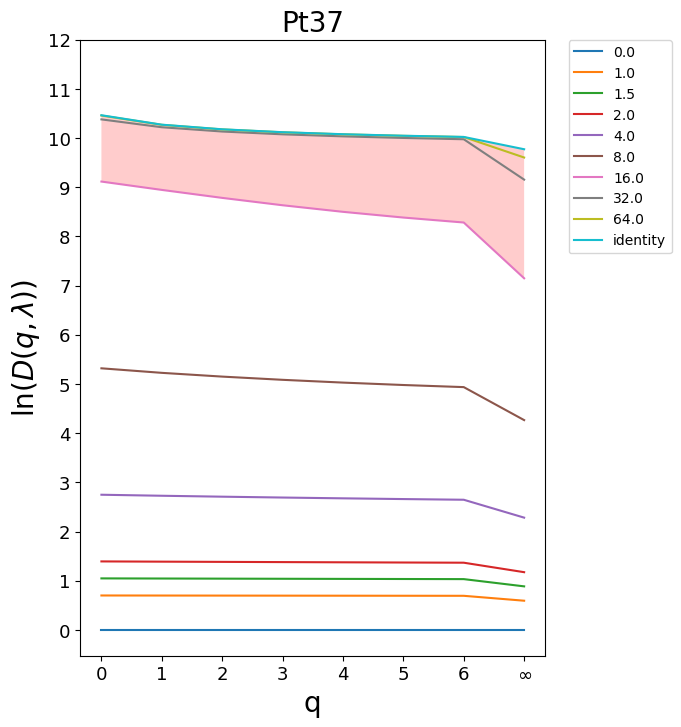

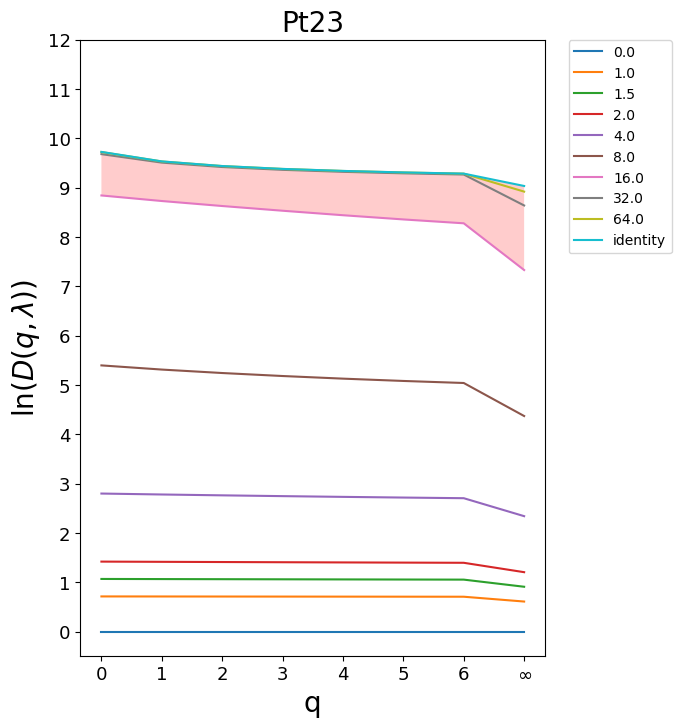

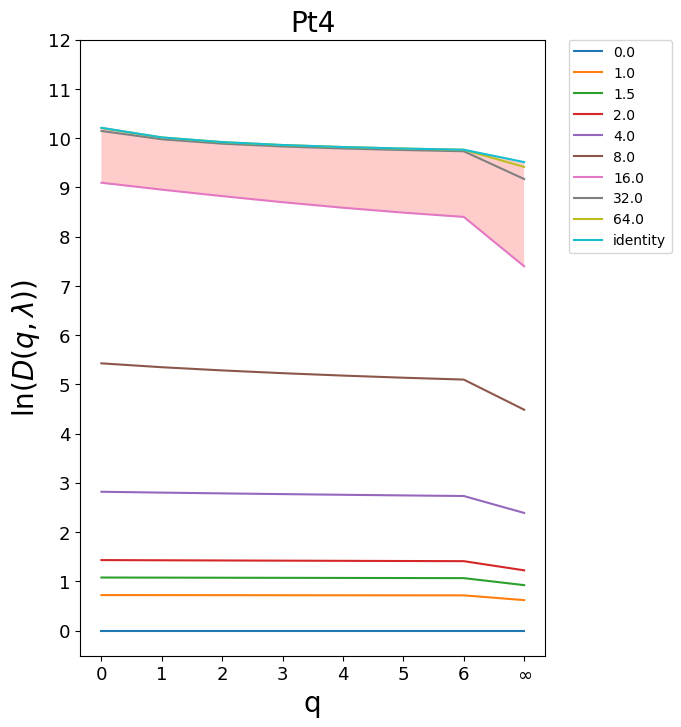

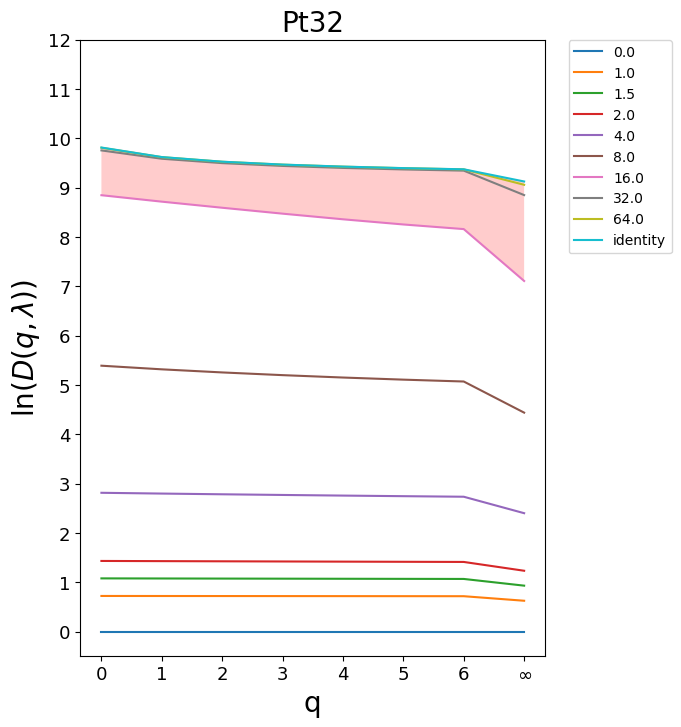

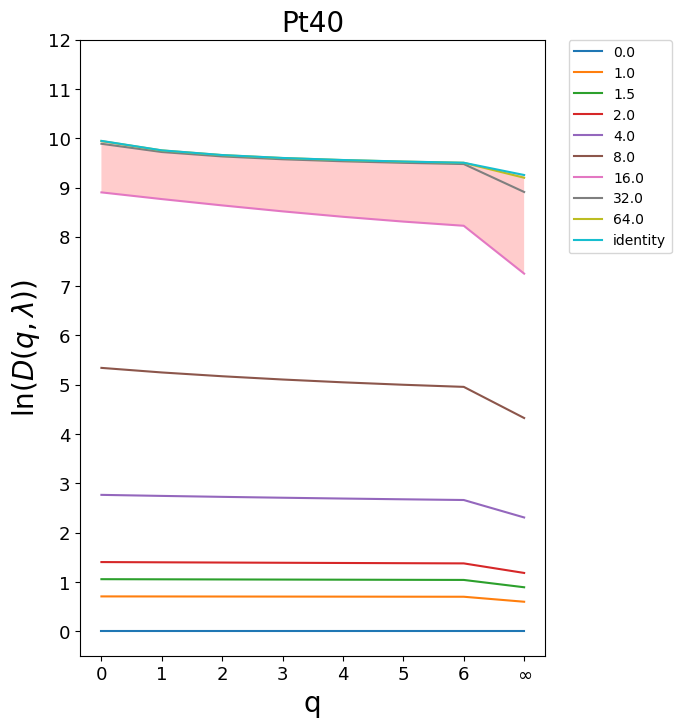

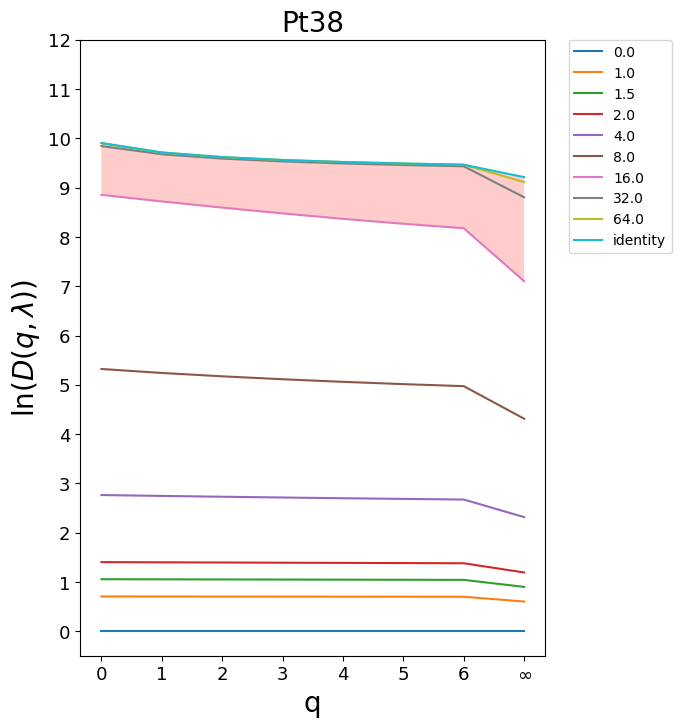

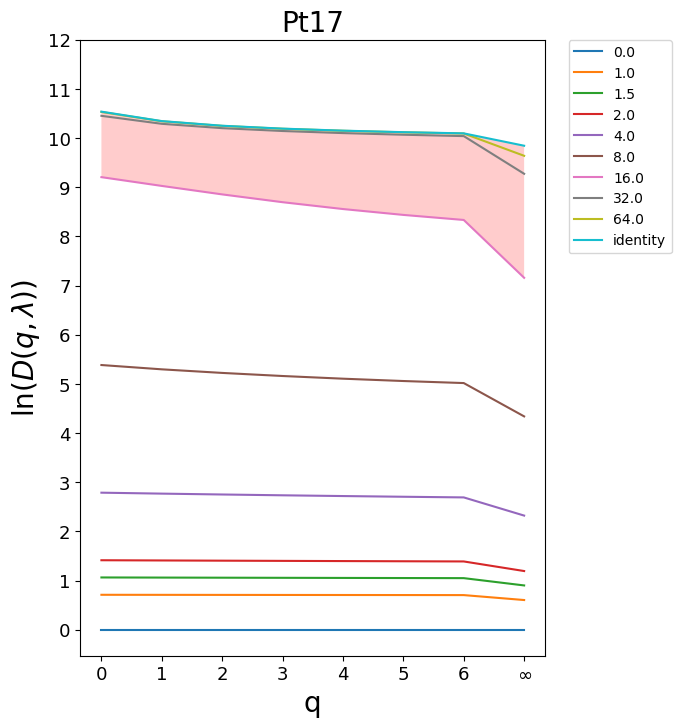

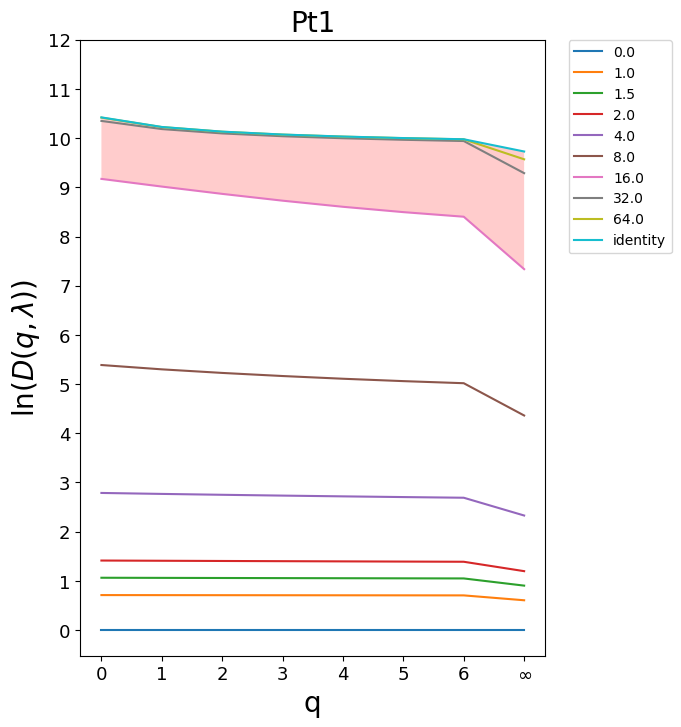

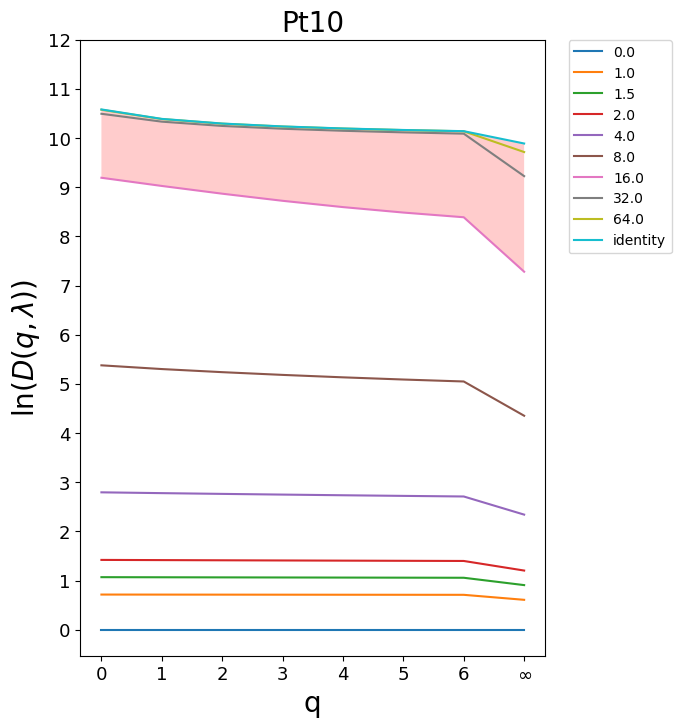

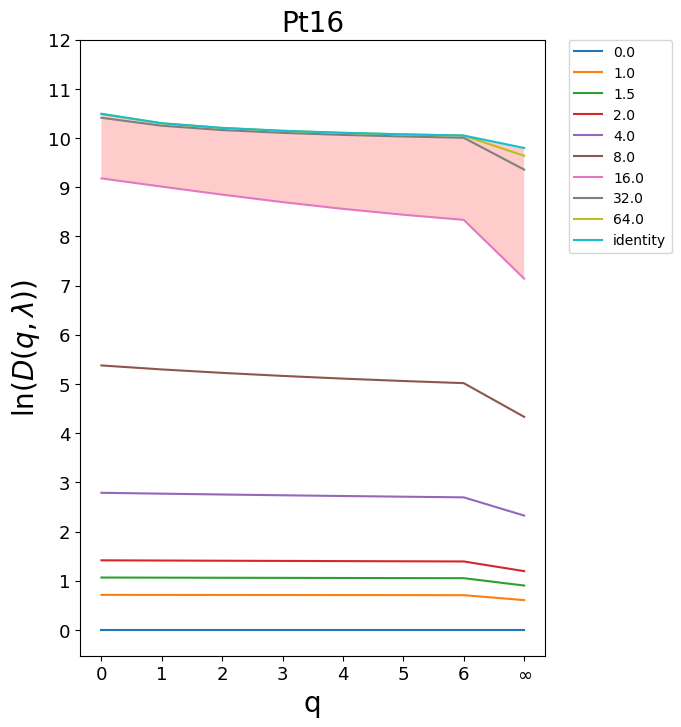

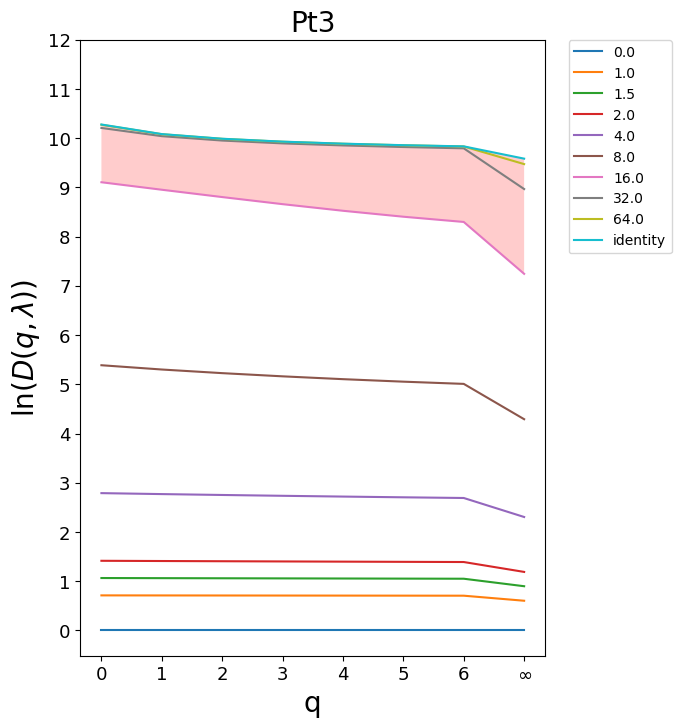

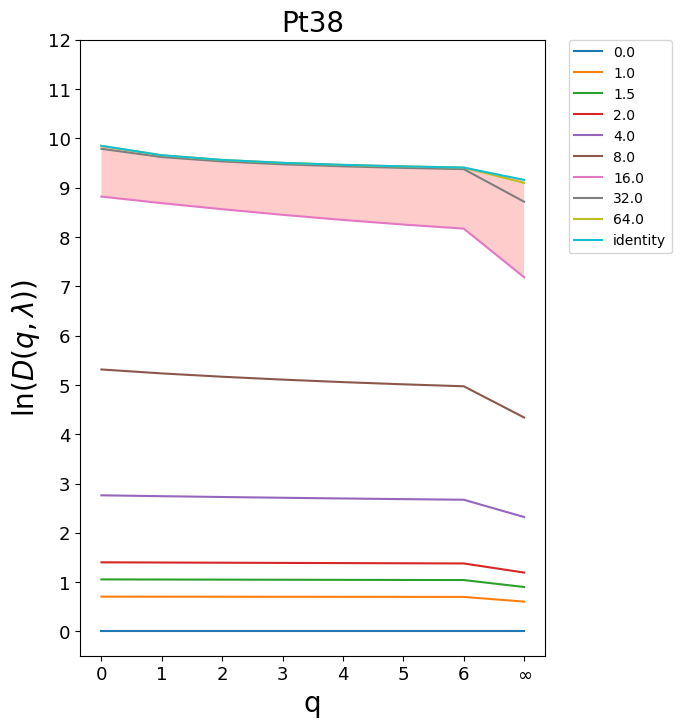

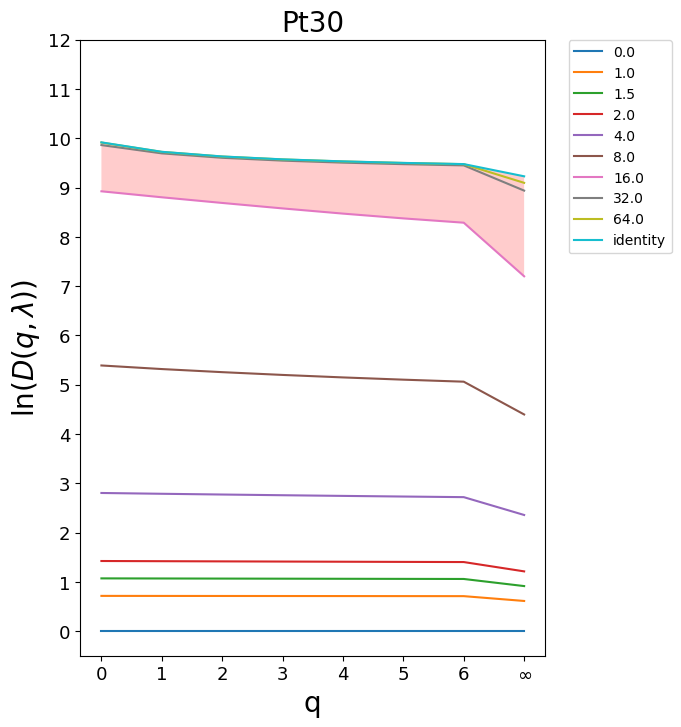

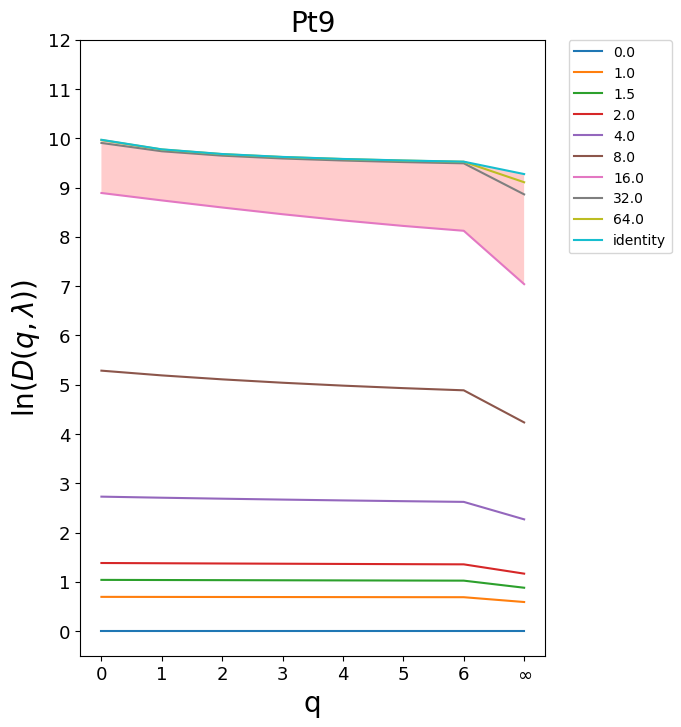

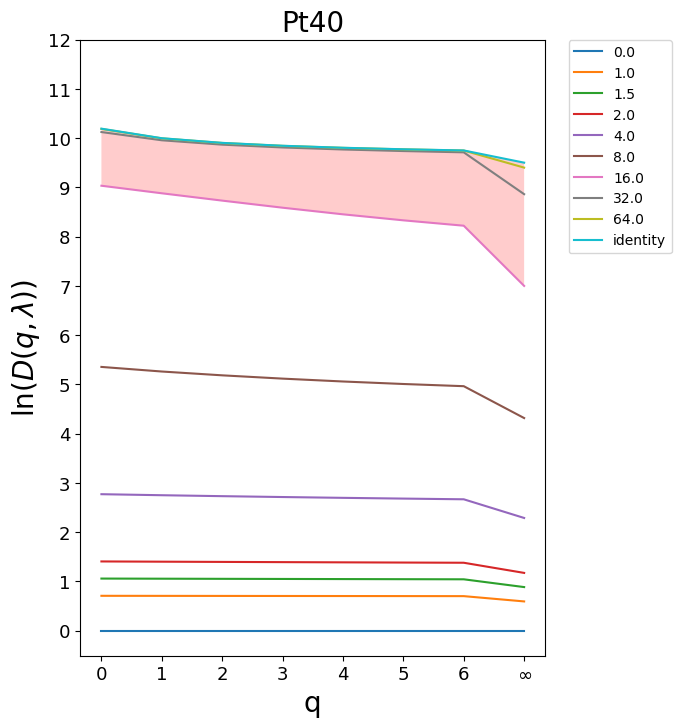

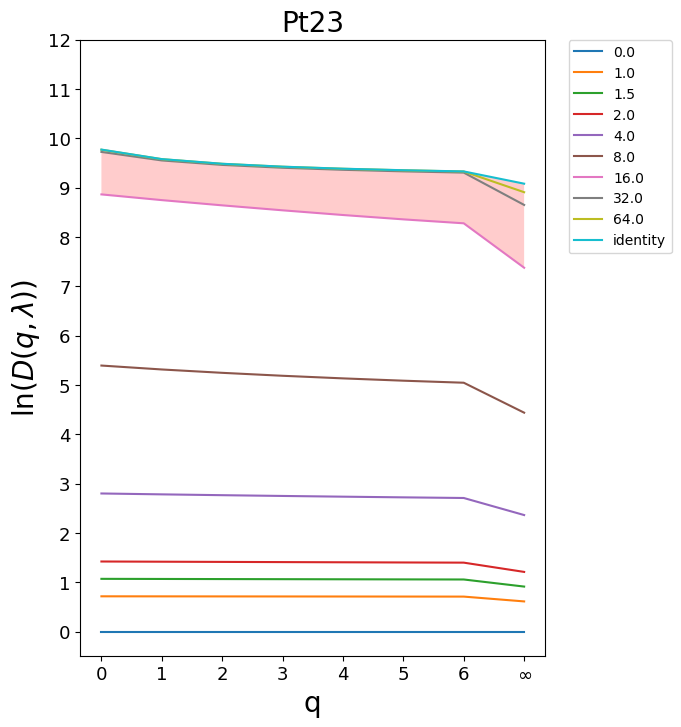

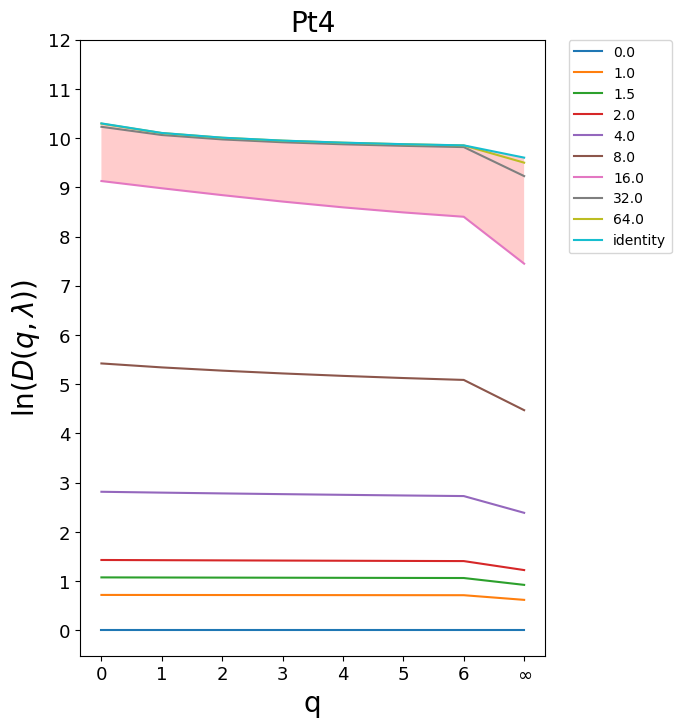

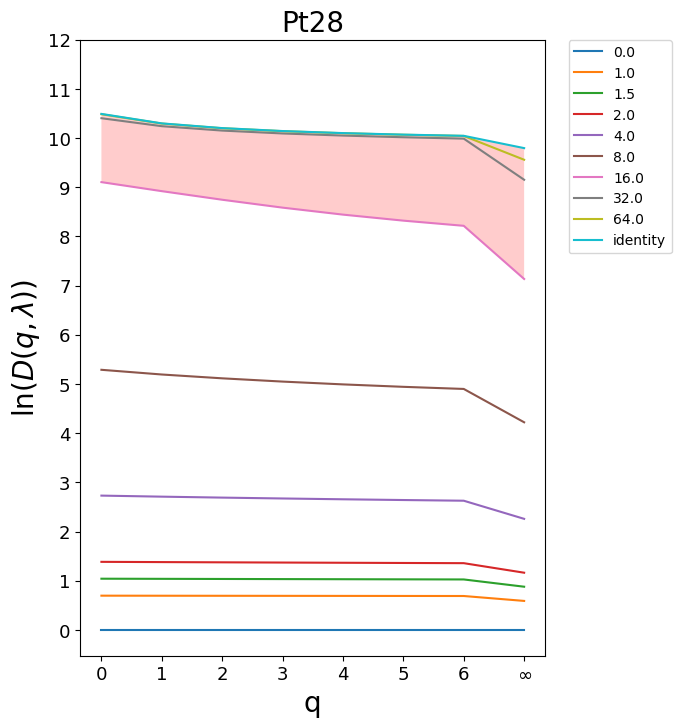

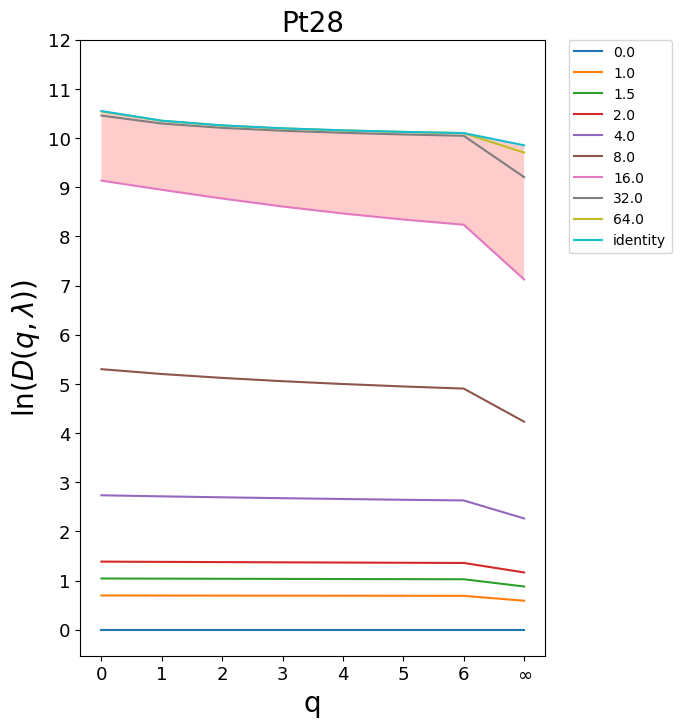

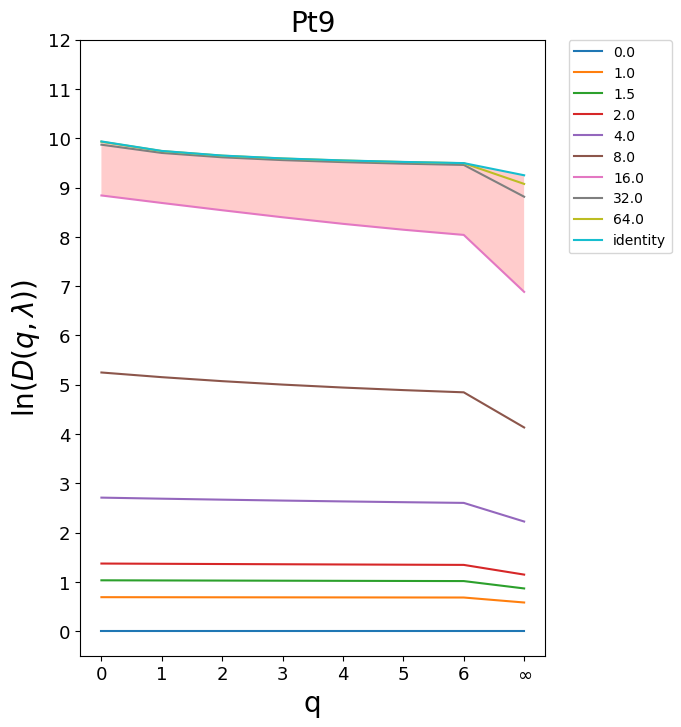

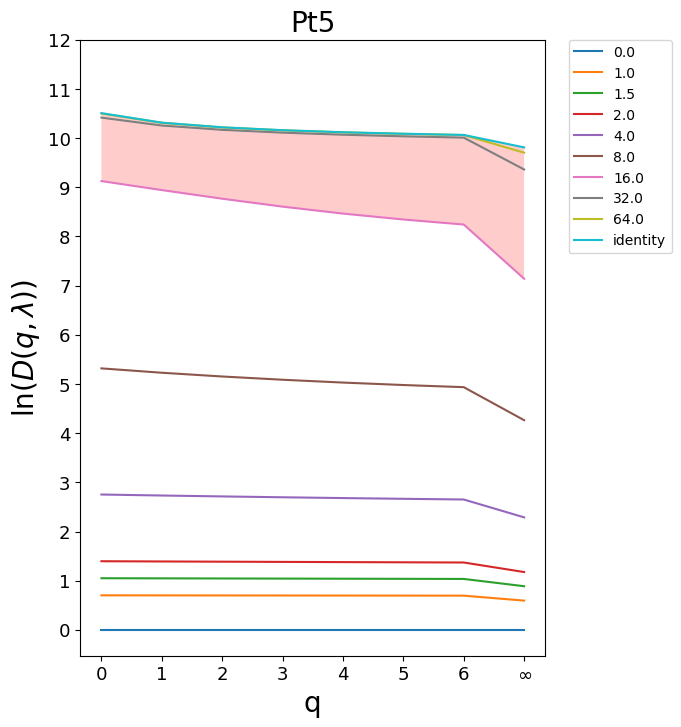

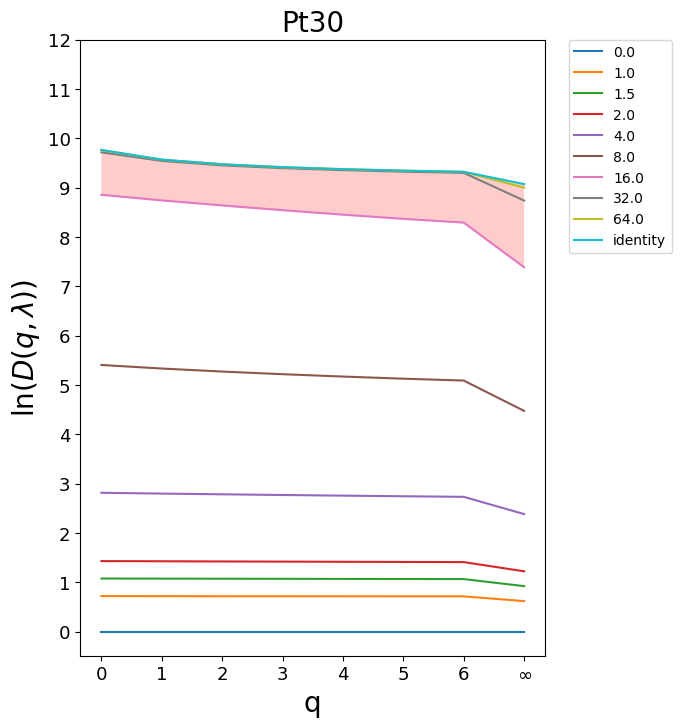

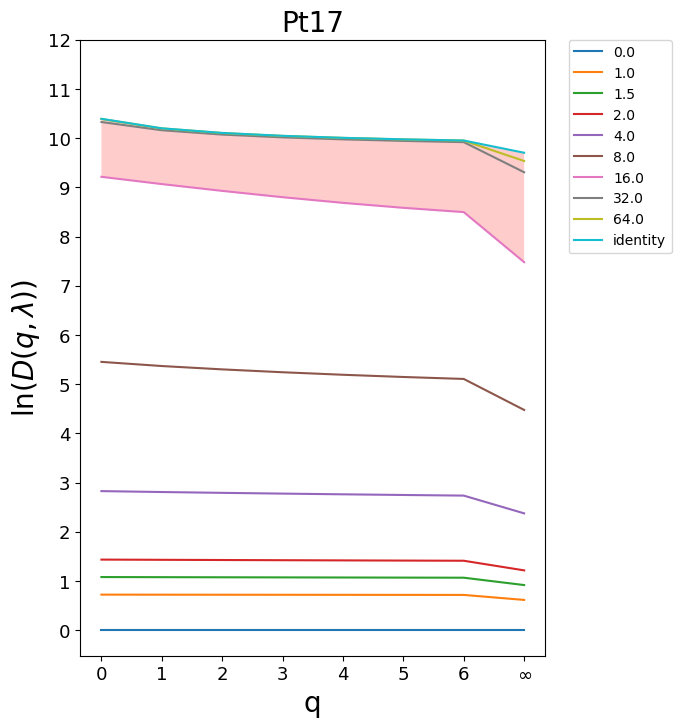

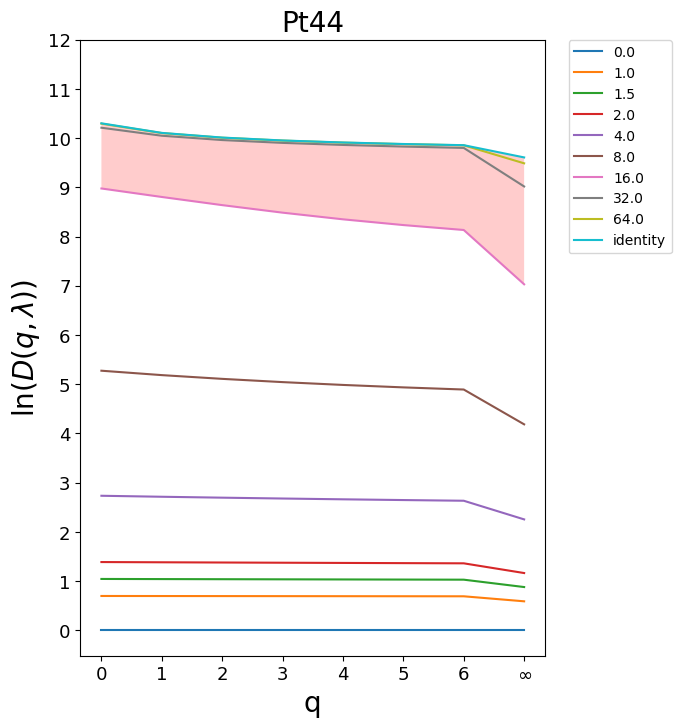

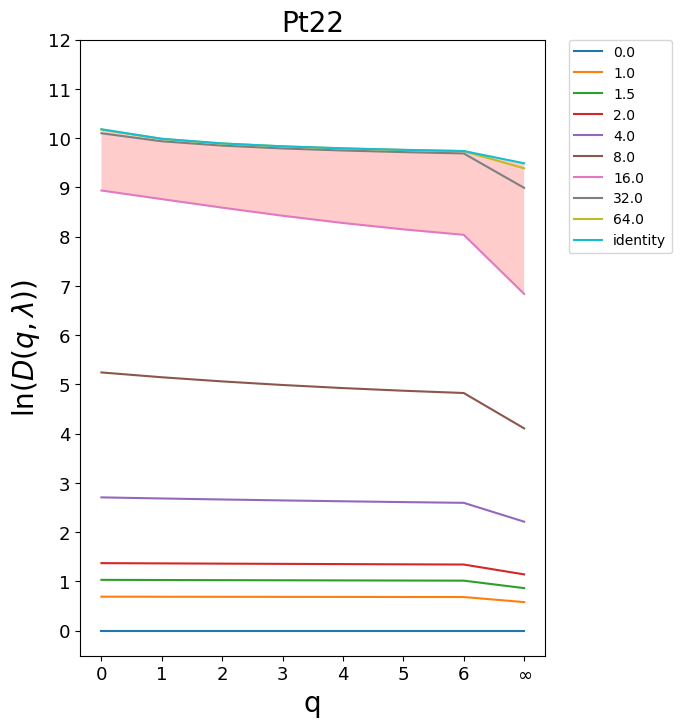

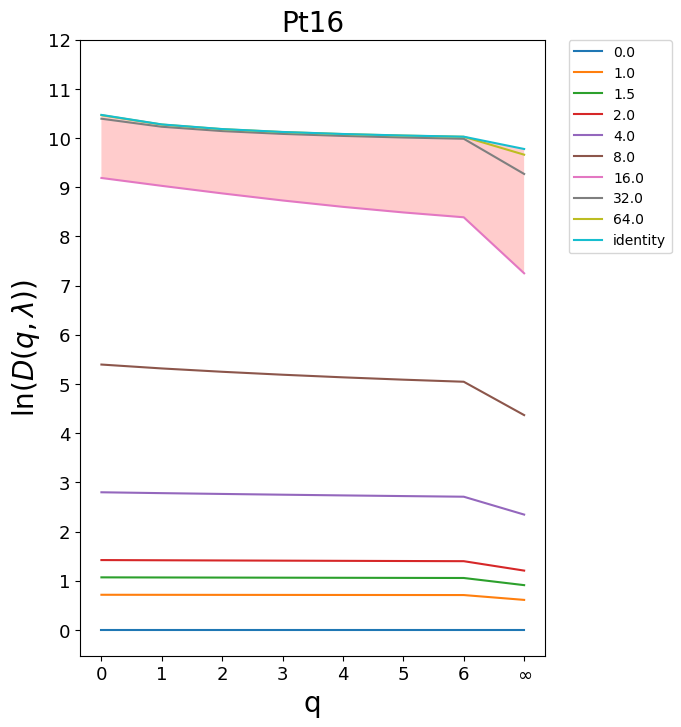

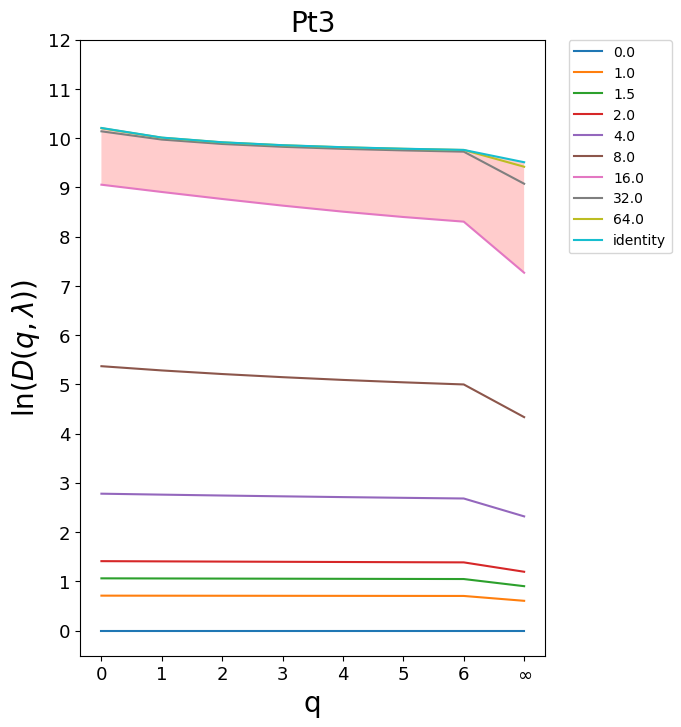

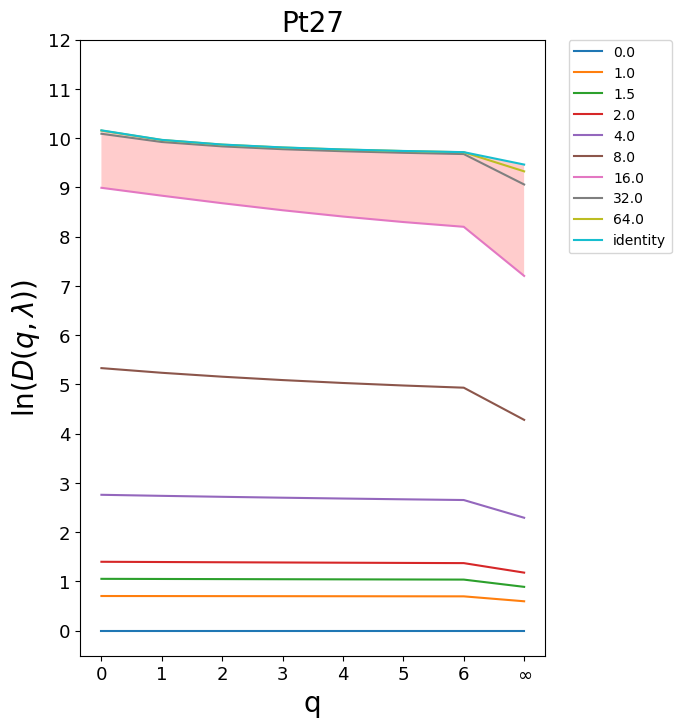

In [10]:
# define divP files 
divP_fpath = wdir_path + "divP_tsv/"
# Initiate empty list to store area dictionaries 
divP_areas = []
divP_slopes = []
average_delta_lambda = []
divP1_all_list = []
# iterate trough files 
for index,row in mddf.iterrows():
    # create pandas dataframes of divPs
    sample_name = row['sample_name']
    patient = row['patient']
    recist = row['RECIST']
    time = row['timepoint']
    divP_df = pd.read_csv(divP_fpath + row['sample_name'] + "_divP.tsv", comment='#', sep = '\t')
    divP_df = divP_df.set_index('q')
    divP_df.insert(0, '0.0', [1]*divP_df.shape[0])
    #ln transform the dataframe
    divP_df = np.log(divP_df)
    qs = divP_df.index.values[:-1]
    qs = np.append(qs, (divP_df.index.values[-2] + 1))
    divP_df["q"] = qs
    #calculate areas dictionary and append to a list
    divP_areas.append(calculate_area_between_curves(divP_df))
    #calculate slopes dictionary and append to a list
    divP_slopes.append(calculate_slopes(divP_df))
    #calculate average delta lambda for small lambda: 
    average_delta_lambda.append(calculate_avg_delta_lambda_05_00(divP_df))
    #convert divP into a row df and append to a list: 
    divP1_all_list.append(make_divP_one_row_df(divP_df))
    #plot divPs
    divP_df = divP_df.drop(["0.1", "0.2", "0.25", "0.3", "0.4", "0.5", "0.75"], axis =1 )
    plt_divP(divP_df, sample_name, time, recist, patient, wdir_path)

divP_areas_df = pd.DataFrame.from_dict(divP_areas)
divP_slopes_df = pd.DataFrame.from_dict(divP_slopes)
average_delta_lambda_df = pd.DataFrame(average_delta_lambda, columns = ["Average area for small lambdas"])
divP1_all_df = pd.concat(divP1_all_list)
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df = pd.concat([divP1_all_df, mddf], axis = 1)

divP_features = pd.concat([divP_areas_df, divP_slopes_df,average_delta_lambda_df, mddf], axis=1)

In [11]:
divP_features = divP_features.rename(columns={"timepoint": "Timepoint", "RECIST": "RECIST criteria"})

In [12]:
divP_features["Timepoint"] = divP_features['Timepoint'].str.replace('Day', '')
divP_features["Timepoint"] = divP_features["Timepoint"].astype(str).astype(int)
divP_features = divP_features.sort_values('Timepoint')
divP_features = divP_features.reset_index(drop = True)
divP_features

identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.084027            0.466791            9.635807   
1             0.043176            0.443595            8.066101   
2             0.071680            0.572502            9.694778   
3             0.095142            0.532166           10.979845   
4             0.093679            0.688405           11.896086   
5             0.122392            0.638713           11.257728   
6             0.038031            0.369374            8.266225   
7             0.045001            0.339191            7.749877   
8             0.060070            0.394366            8.835639   
9             0.098816            0.441078            8.918239   
10            0.044934            0.325927            6.765512   
11            0.065542            0.339860            6.613901   
12            0.082818            0.674403           11.487570   
13            0.079950            0.655596           11.023552   
14            0.070611            0.591196           10.078921   
15            0.069922            0.570930           10.722913   
16            0.072007            0.488689           10.538634   
17            0.108488            0.659721           11.796141   
18            0.091109            0.647899           11.119738   
19            0.061357            0.629512           11.582040   
20            0.072897            0.588083           11.623830   
21            0.097913            0.432411            9.430210   
22            0.103774            0.468387            9.208456   
23            0.137780            0.684043           11.652764   
24            0.073188            0.543111           10.538923   
25            0.064521            0.435335            9.344788   
26            0.097686            0.381456            6.853433   
27            0.059316            0.590442           10.696146   
28            0.078242            0.335557            7.746102   
29            0.104330            0.675148           11.332423   
30            0.060005            0.463794            9.334767   
31            0.063529            0.429202            8.351762   
32            0.101100            0.628130           11.173110   
33            0.064886            0.423581            8.332572   
34            0.045616            0.441561            8.471166   
35            0.106574            0.609497           10.483853   
36            0.072707            0.583403           10.048429   
37            0.072016            0.583323           11.178222   
38            0.064752            0.576817            9.703428   
39            0.092592            0.475359           10.150440   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           33.460736          50.004947          59.105780   
1           31.157870          47.757955          56.902793   
2           33.817955          50.595438          59.813213   
3           35.312140          52.097670          61.329959   
4           36.399895          52.879366          61.902031   
5           35.616605          52.414498          61.640191   
6           31.843059          48.466856          57.600036   
7           30.272115          47.092874          56.436950   
8           32.809905          49.837455          59.199188   
9           32.460005          48.881557          57.885351   
10          29.770370          46.740098          56.091847   
11          29.790653          46.646261          55.916941   
12          35.669790          52.091205          61.100841   
13          34.792474          51.151285          60.168221   
14          33.009014          49.085071          57.952091   
15          34.359460          50.568989          59.473127   
16          34.996743          51.706930          60.872323   
17          35.994236          52.451295          61.496489   
18          35.096210          51.651615          60.773986   
19          35.894284          52.680

In [13]:
divP1_all_df = divP1_all_df.rename(columns={"timepoint": "Timepoint", "RECIST": "RECIST criteria"})
divP1_all_df["Timepoint"] = divP1_all_df['Timepoint'].str.replace('Day', '')
divP1_all_df["Timepoint"] = divP1_all_df["Timepoint"].astype(str).astype(int)
divP1_all_df = divP1_all_df.sort_values('Timepoint')
divP1_all_df = divP1_all_df.reset_index(drop = True)
divP1_all_df


L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.070843  0.070831   0.07082  0.070808  0.070796  0.070785  0.070773   
1    0.07102   0.07101     0.071   0.07099   0.07098  0.070971  0.070961   
2   0.071597  0.071587  0.071576  0.071565  0.071555  0.071544  0.071534   
3   0.071664  0.071654  0.071644  0.071634  0.071624  0.071615  0.071605   
4   0.070138  0.070126  0.070114  0.070102  0.070091  0.070079  0.070067   
5   0.071628  0.071618  0.071607  0.071597  0.071586  0.071576  0.071565   
6   0.070993  0.070981   0.07097  0.070958  0.070947  0.070935  0.070924   
7   0.072588   0.07258  0.072571  0.072563  0.072554  0.072546  0.072537   
8   0.072543  0.072534  0.072524  0.072515  0.072505  0.072496  0.072486   
9   0.069939  0.069927  0.069915  0.069904  0.069892   0.06988  0.069869   
10    0.0725  0.072491  0.072483  0.072474  0.072465  0.072456  0.072448   
11  0.071982  0.071972  0.071961  0.071951  0.071941  0.071931  0.071921   
12  0.070055  0.070044  0.070033  0.070021   0.07001  0.069999  0.069988   
13  0.070289  0.070278  0.070267  0.070256  0.070245  0.070234  0.070224   
14  0.069154  0.069142   0.06913  0.069119  0.069107  0.069095  0.069084   
15  0.069343  0.069331  0.069319  0.069307  0.069295  0.069283  0.069271   
16  0.071173  0.071163  0.071152  0.071141  0.071131   0.07112   0.07111   
17  0.070335  0.070324  0.070313  0.070301   0.07029  0.070279  0.070268   
18   0.07104  0.071029  0.071018  0.071008  0.070997  0.070986  0.070976   
19  0.071845  0.071836  0.071827  0.071817  0.071808  0.071799   0.07179   
20  0.070662  0.070651   0.07064   0.07063  0.070619  0.070608  0.070597   
21  0.072614  0.072604  0.072594  0.072584  0.072574  0.072564  0.072554   
22  0.069454  0.069442  0.069431  0.069419  0.069407  0.069396  0.069384   
23  0.070028  0.070016  0.070004  0.069993  0.069981   0.06997  0.069958   
24  0.071982  0.071972  0.071963  0.071953  0.071944  0.071934  0.071924   
25  0.072444  0.072434  0.072425  0.072415  0.072406  0.072396  0.072387   
26  0.072002  0.071992  0.071982  0.071972  0.071963  0.071953  0.071943   
27  0.071265  0.071254  0.071243  0.071233  0.071222  0.071212  0.071201   
28  0.072242  0.072233  0.072224  0.072215  0.072206  0.072198  0.072189   
29  0.071945  0.071936  0.071927  0.071917  0.071908  0.071899   0.07189   
30  0.071376  0.071366  0.071355  0.071345  0.071334  0.071324  0.071313   
31  0.071108  0.071098  0.071088  0.071078  0.071068  0.071059  0.071049   
32  0.070547  0.070536  0.070525  0.070514  0.070503  0.070491   0.07048   
33  0.072092  0.072083  0.072074  0.072066  0.072057  0.072048  0.072039   
34  0.069673  0.069662   0.06965  0.069639  0.069627  0.069616  0.069604   
35  0.070682  0.070671  0.070661   0.07065   0.07064  0.070629  0.070619   
36  0.069554  0.069543  0.069531  0.069519  0.069508  0.069496  0.069485   
37  0.069604  0.069592   0.06958  0.069568  0.069555  0.069543  0.069531   
38  0.071106  0.071095  0.071083  0.071072  0.071061  0.071049  0.071038   
39  0.071562  0.071552  0.071541   0.07153   0.07152  0.071509  0.071499   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0    0.060464  0.141598  0.141551  ...       9.771977       9.741266   
1    0.061154  0.141946  0.141907  ...       9.462426       9.431526   
2    0.061051  0.143106  0.143064  ...       9.888512        9.85772   
3    0.061224  0.143235  0.143196  ...      10.107493      10.076478   
4    0.059776  0.140191  0.140144  ...      10.157226      10.126257   
5    0.061261  0.143167  0.143125  ...       10.15082      10.119998   
6     0.06039  0.141899  0.141852  ...       9.559559       9.528519   
7    0.063097  0.145073  0.145039  ...       9.427236       9.396605   
8    0.062519  0.144991  0.144953  ...       9.820741       9.789902   
9      0.0598  0.139795  0.139748  ...       9.580777       9.549988   
10   0.062525  0.144902  0.144866  ...       9.376397        9.34614   
11   0.061846  0.14387

## Plot Naive diversity profile without similarity for all samples 

In [14]:
divP_identity = divP1_all_df.copy()

In [15]:
divP_identity = divP_identity[[div for div in list(divP_identity) if "identity" in div] + ["Timepoint","RECIST criteria", "sample_name"]]

In [16]:
divP_identity["TimePoint_Recist"] = divP_identity.apply( lambda row: row["RECIST criteria"] + 
                                                      "_day_" + str(row["Timepoint"]), axis = 1)



In [17]:
divP_identity_list = []
qDzs = [div for div in list(divP_identity) if div.startswith("L")]
for index, row in divP_identity.iterrows():
    for column in qDzs:
        divP_identity_list.append([row["sample_name"], int(column.split("_")[-1]), 
                                   row[column], 
                                   row["TimePoint_Recist"],row["RECIST criteria"], 
                                   row["Timepoint"]])
        
        
        

In [18]:
divP_identity_plt_df = pd.DataFrame(divP_identity_list, columns = ["sample_name", "q", "qDZ",
                                                                   "TimePoint_Recist", "RECIST criteria", 
                                                                   "Timepoint"])

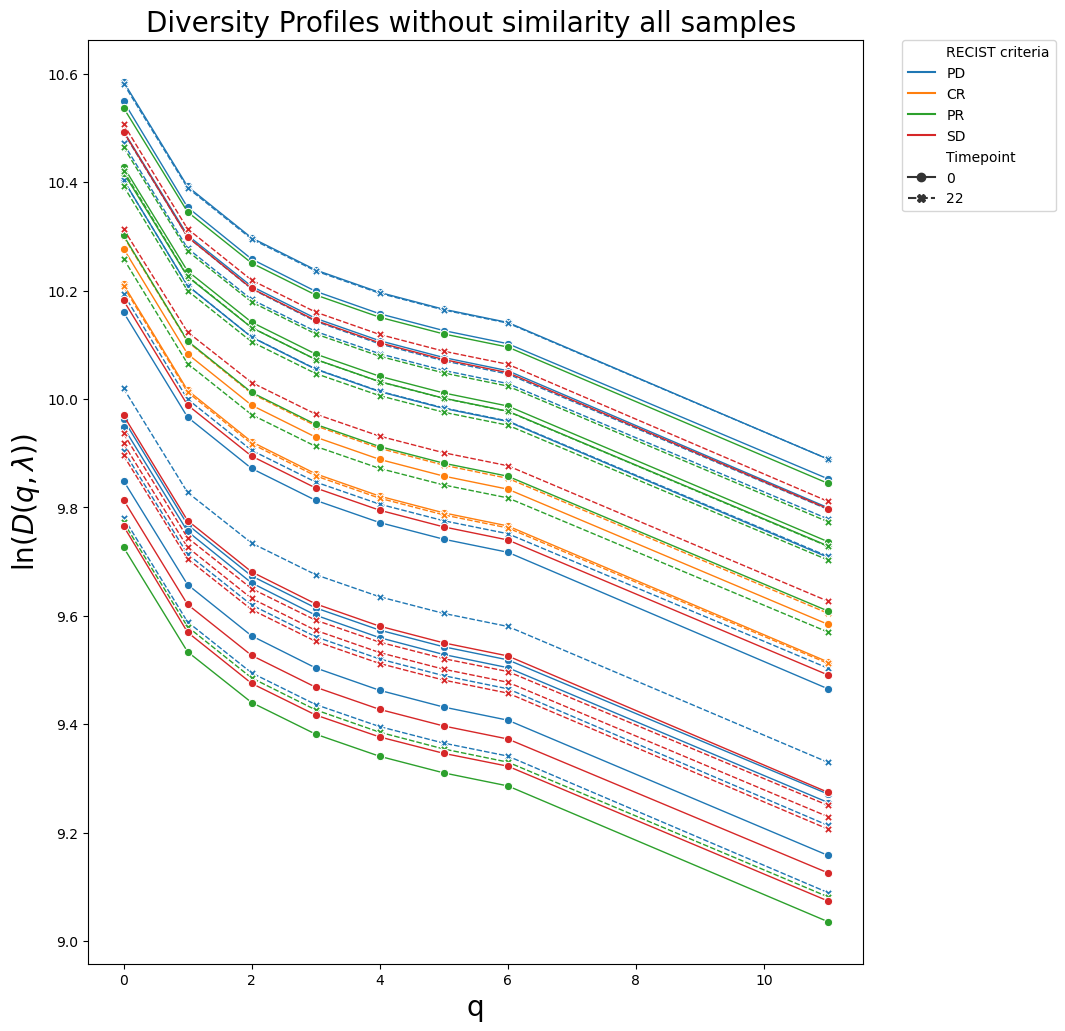

In [19]:
plt.figure(figsize=(10,12))
sns.color_palette("colorblind")
ax =sns.lineplot(data=divP_identity_plt_df, x="q", y="qDZ", hue="RECIST criteria", style="Timepoint", units="sample_name", markers=True, estimator = None, lw=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.xlabel("q", fontsize = 20)
plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
plt.title("Diversity Profiles without similarity all samples ", fontsize = 20)
plt.savefig(wdir_path + "Diversity_profiles_ID_all_samples.png", bbox_inches='tight')
plt.show()
plt.close()
    



## All samples
### important features corrplot

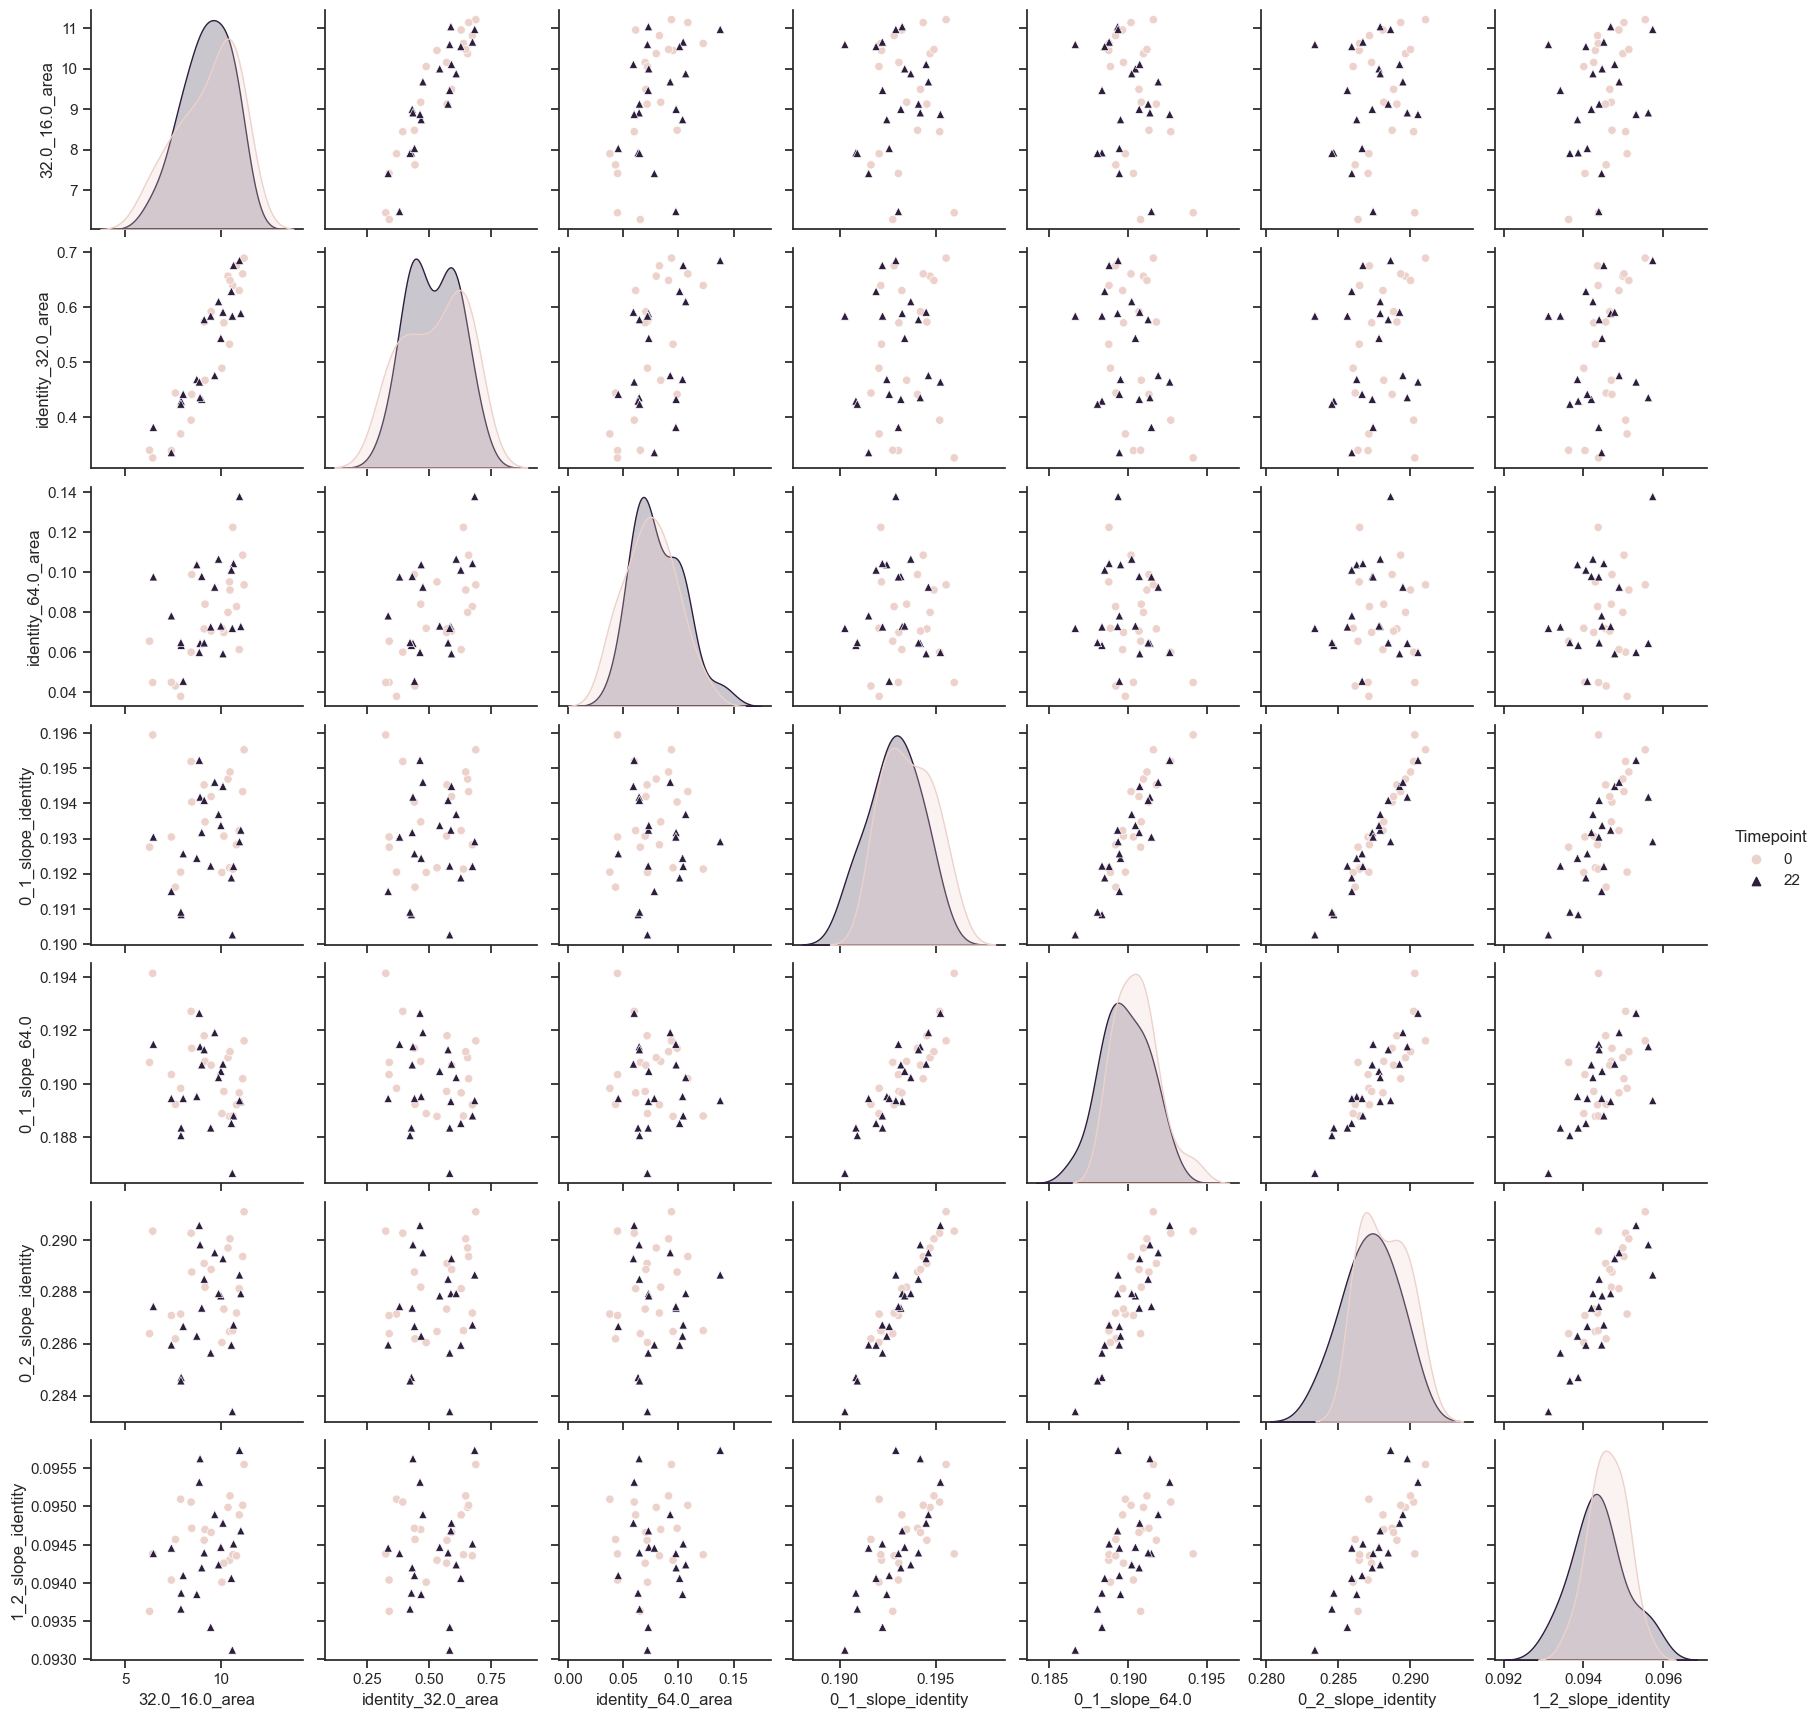

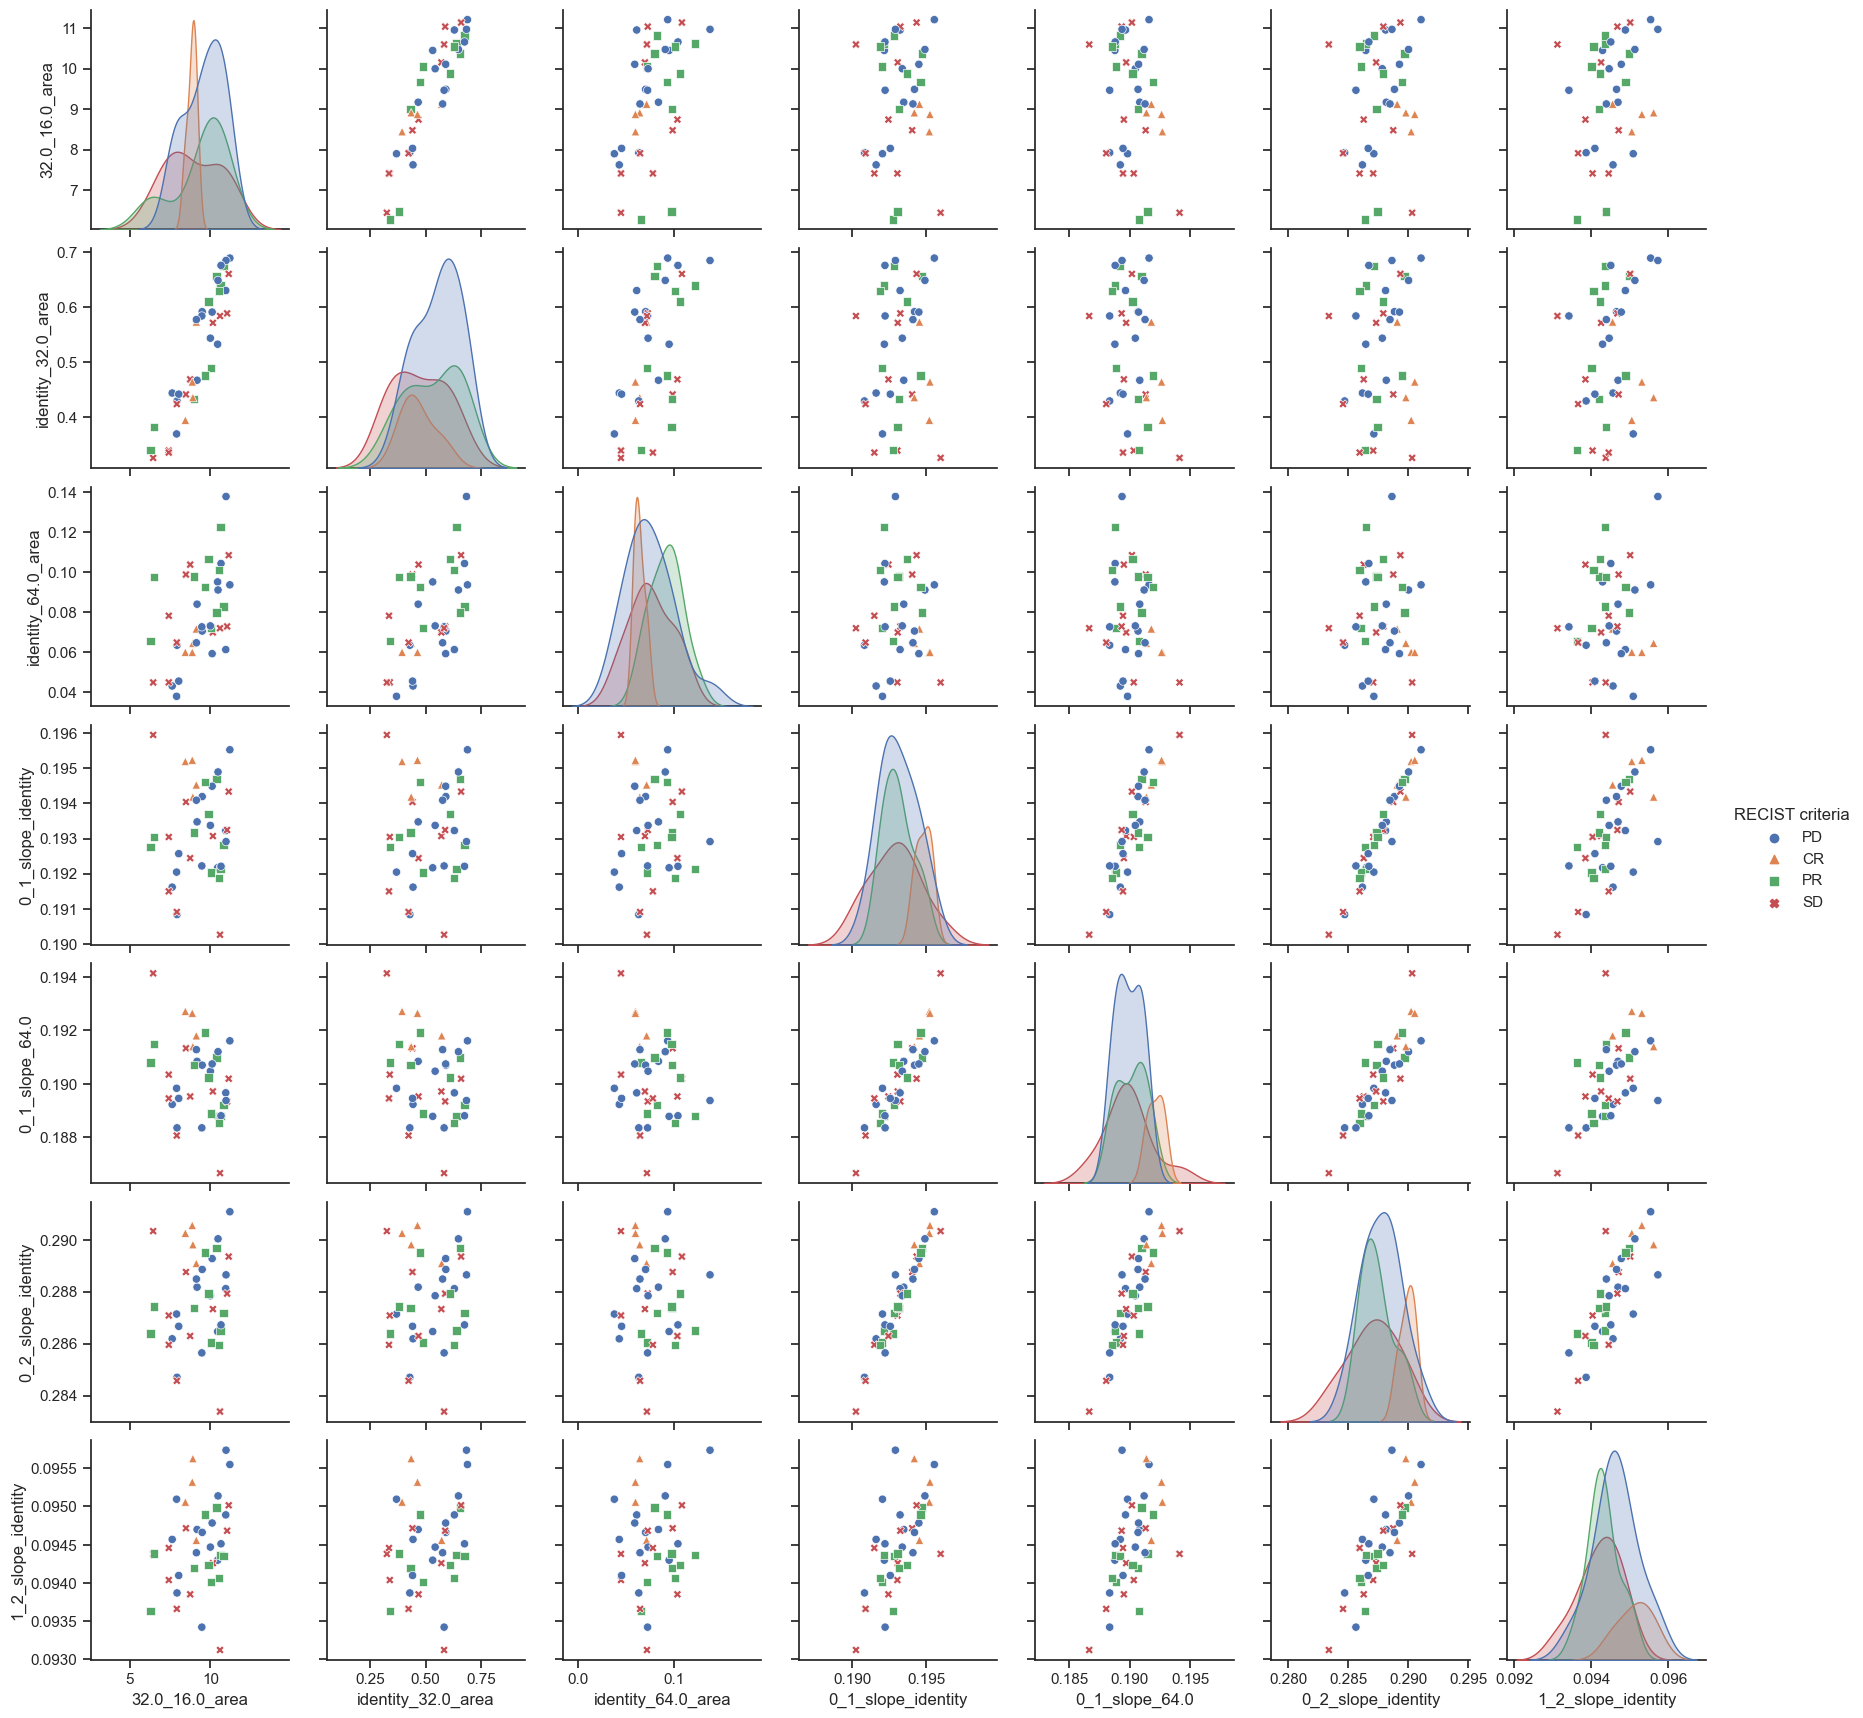

In [20]:
all_features = divP_features.copy()
important_ft = ["32.0_16.0_area", 
                "identity_32.0_area",
                "identity_64.0_area", 
                "0_1_slope_identity", 
                "0_1_slope_64.0", 
                "0_2_slope_identity", 
                "1_2_slope_identity",  
                "RECIST criteria", 
               "Timepoint"]
divP_impr_ft = divP_features[important_ft]

sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Timepoint", markers = ["o", "^"])
pairplot.savefig(wdir_path + "features_pairplot_timepoint.pdf")
pairplot

divP_impr_ft = divP_impr_ft.drop(['Timepoint'], axis=1)
sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="RECIST criteria", markers = ["o", "^", "s", "X"])
pairplot.savefig(wdir_path + "features_pairplot_RECIST.pdf")
pairplot


### Selected features scatterplot 

In [21]:
def plot_selected_ft_scatterplot(ft1, ft2, hue_cat, style_cat, xlabel_f1, ylabel_ft2, wdir_path, divP_features_df, legend_opt = True):
    fig, ax = plt.subplots(figsize=(8,8))
    cmap = sns.color_palette("colorblind", len(list(set(divP_features_df[hue_cat]))))
    p = sns.scatterplot(x=ft1, y=ft2, 
                     data=divP_features_df,
                     hue=hue_cat, palette=cmap,  
                     style = style_cat, 
                     s = 140, legend = legend_opt
                     )
    if legend_opt:
        p.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(fontsize = 20, rotation=45)
    plt.yticks(fontsize = 20)
    plt.xlabel(xlabel_f1, fontsize = 26)
    plt.ylabel(ylabel_ft2, fontsize = 26)
    plt.tight_layout()
    if not os.path.isdir(wdir_path):
        os.makedirs(wdir_path, exist_ok=False)
    plt.savefig(wdir_path  + ft1 + "_" + ft2 + "_scatterplot.pdf")
    plt.show()
    plt.close()


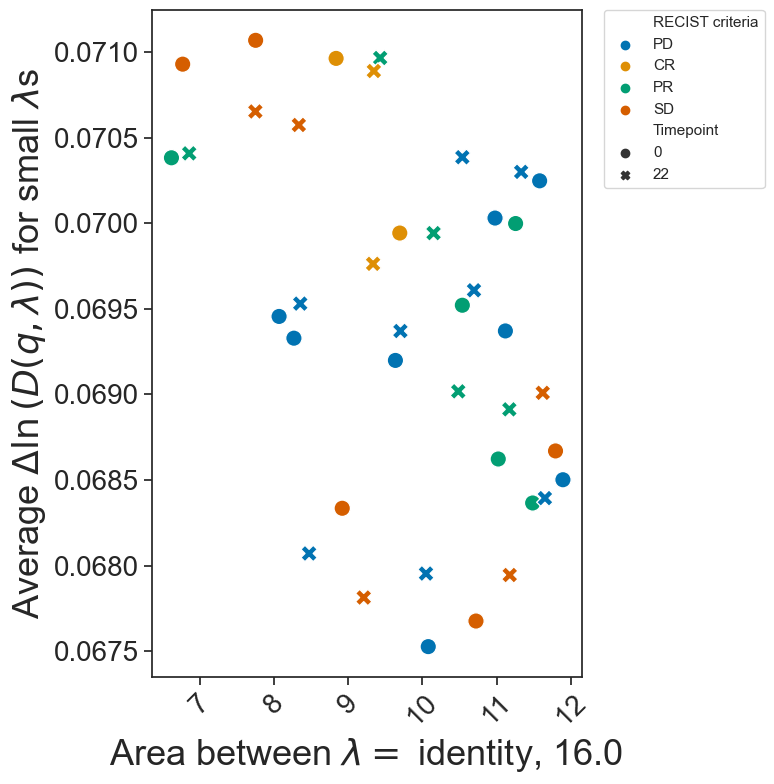

In [22]:
# delta lambda vs ID 16 area
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "RECIST criteria", "Timepoint", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, True)


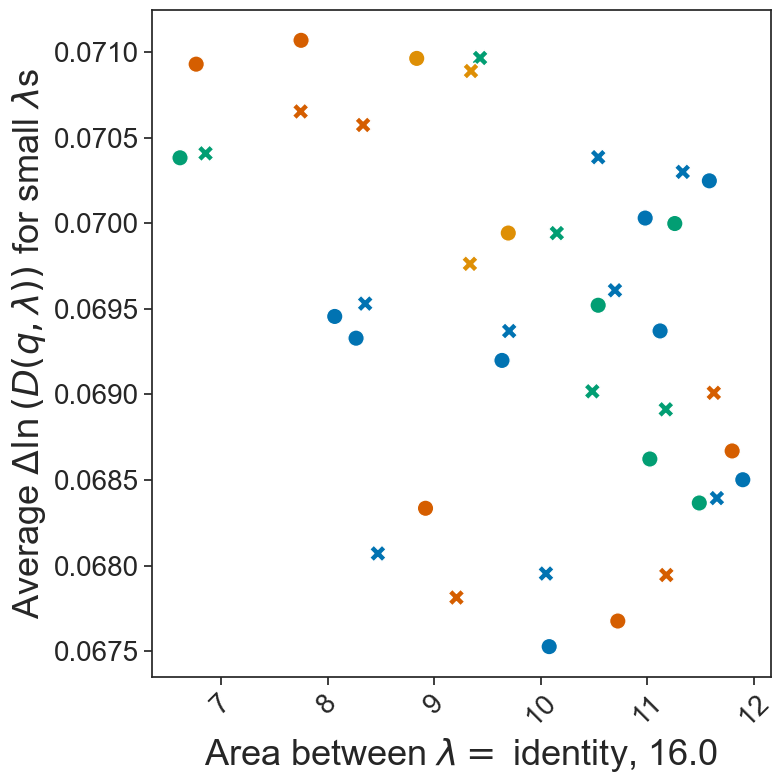

In [23]:
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                                        "RECIST criteria", "Timepoint",
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


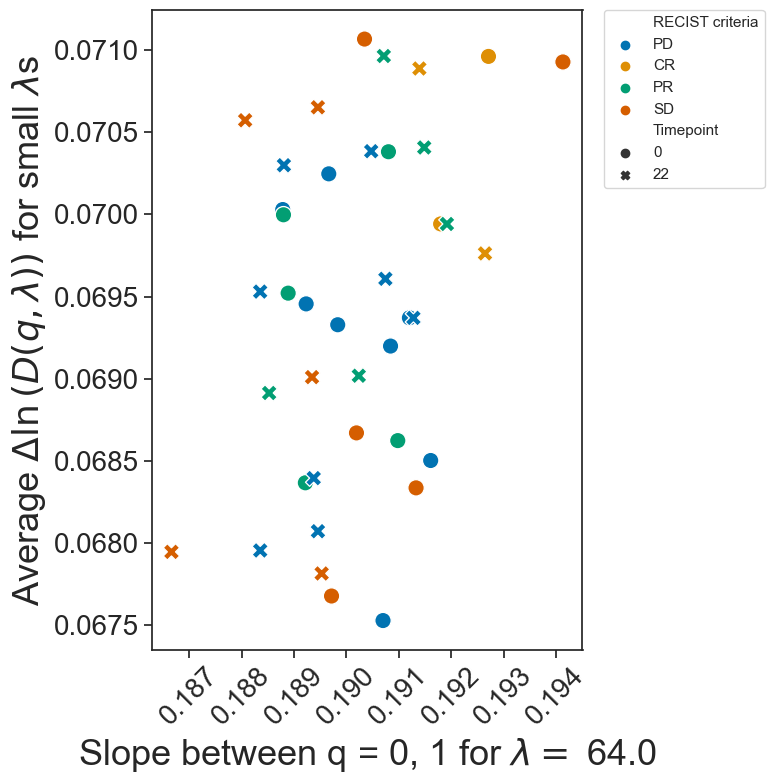

In [24]:
# delta lambda vs 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features)


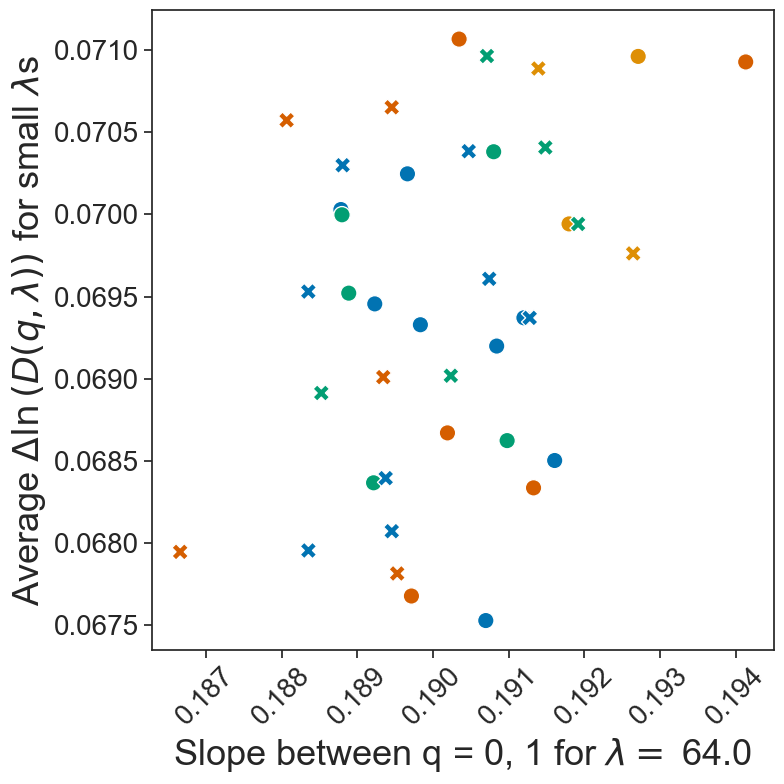

In [25]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


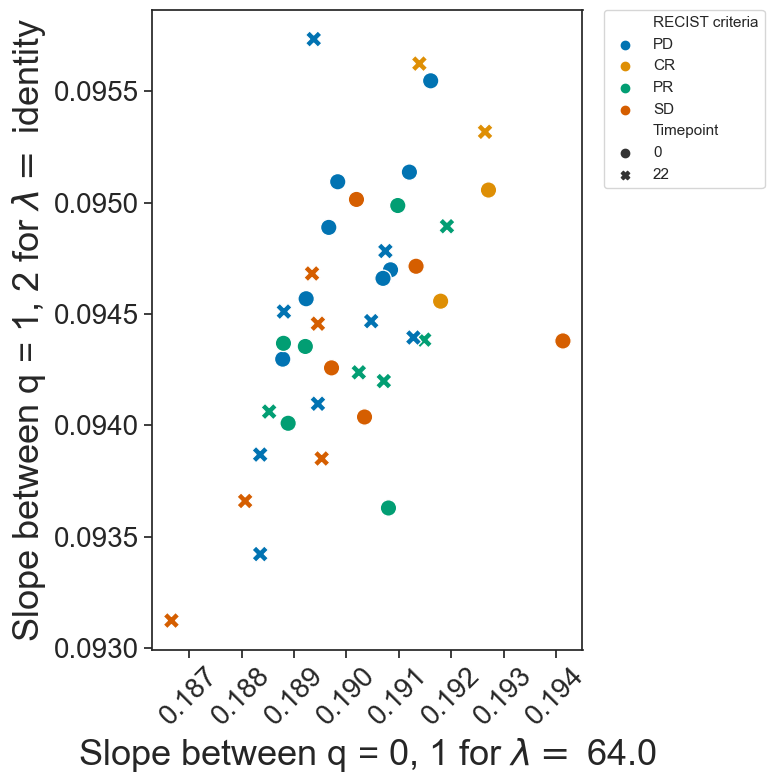

In [26]:
# 1-2 slope ID 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

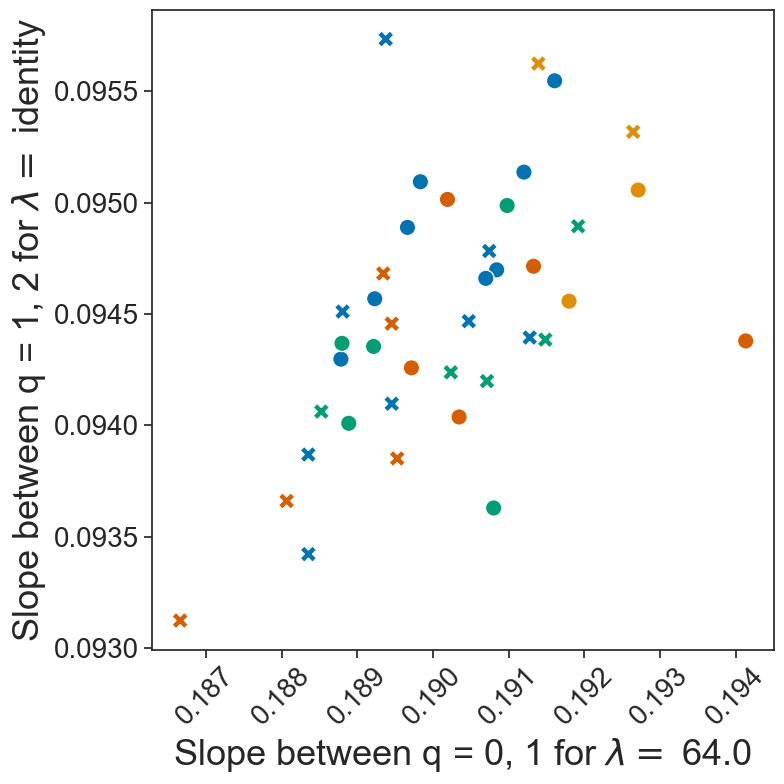

In [27]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "RECIST criteria", "Timepoint",
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

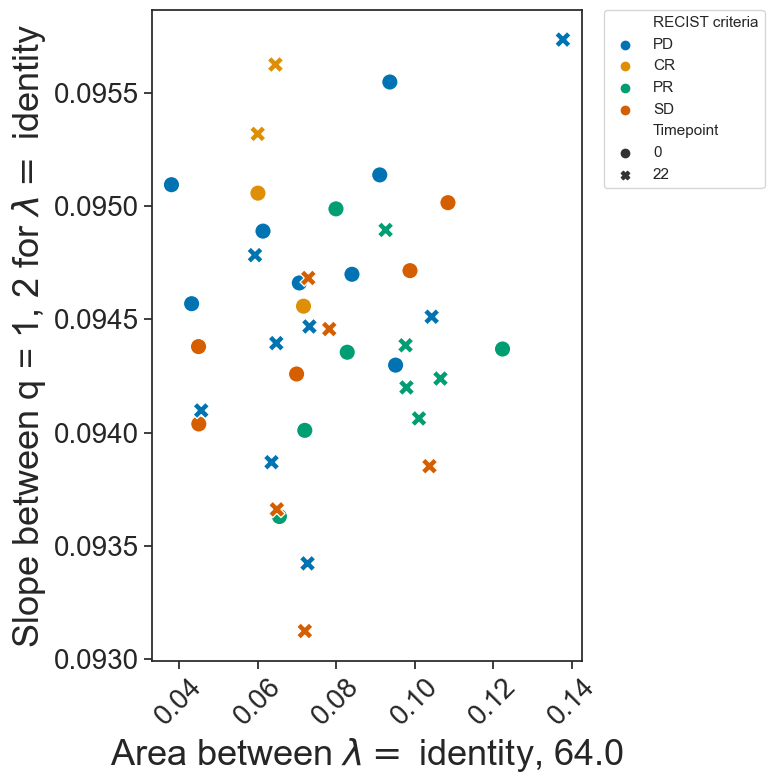

In [28]:
# 1-2 slope ID  ID 64 area

plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "RECIST criteria", "Timepoint", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

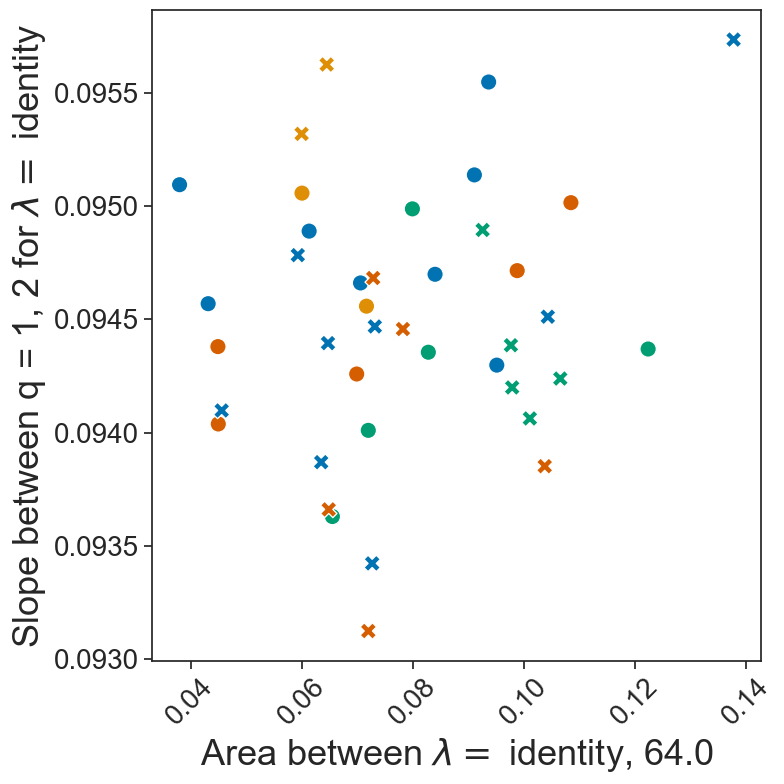

In [29]:
plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "RECIST criteria", "Timepoint",
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

### Lineplot of areas and slope 


In [30]:
hm_ft_df =divP_features[["sample_name", "RECIST criteria", "Timepoint" ,"Average area for small lambdas","identity_16.0_area","0_1_slope_identity"]]

hm_ft_df["sample_name"] = [" ".join([row["RECIST criteria"], " ", str(row["Timepoint"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
hm_ft_df["Regime"] = [" ".join([row["RECIST criteria"], " Day ", str(row["Timepoint"])]) for index,row in hm_ft_df.iterrows()]
#hm_ft_df = hm_ft_df.set_index("sample_name")
hm_ft_df = hm_ft_df.sort_values(by=['Timepoint', "RECIST criteria"])
hm_ft_df


/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50343/135717014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["sample_name"] = [" ".join([row["RECIST criteria"], " ", str(row["Timepoint"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50343/135717014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["Regime"] = [" ".join([row["RECIST criteria"], " Day ", str(row["Timepoint"])]) for index,row in

sample_name RECIST criteria  Timepoint  \
2      CR   0   Pt3_CR_PBMC_Day0              CR          0   
8      CR   0   Pt4_CR_PBMC_Day0              CR          0   
0     PD   0   Pt27_PD_PBMC_Day0              PD          0   
1     PD   0   Pt38_PD_PBMC_Day0              PD          0   
3     PD   0   Pt16_PD_PBMC_Day0              PD          0   
4     PD   0   Pt28_PD_PBMC_Day0              PD          0   
6     PD   0   Pt40_PD_PBMC_Day0              PD          0   
14    PD   0   Pt36_PD_PBMC_Day0              PD          0   
18    PD   0   Pt43_PD_PBMC_Day0              PD          0   
19    PD   0   Pt10_PD_PBMC_Day0              PD          0   
5     PR   0   Pt17_PR_PBMC_Day0              PR          0   
11    PR   0   Pt23_PR_PBMC_Day0              PR          0   
12    PR   0   Pt37_PR_PBMC_Day0              PR          0   
13    PR   0   Pt44_PR_PBMC_Day0              PR          0   
16     PR   0   Pt1_PR_PBMC_Day0              PR          0   
7     SD   0   Pt32_SD_PBMC_Day0              SD          0   
9      SD   0   Pt9_SD_PBMC_Day0              SD          0   
10    SD   0   Pt30_SD_PBMC_Day0              SD          0   
15    SD   0   Pt22_SD_PBMC_Day0              SD          0   
17     SD   0   Pt5_SD_PBMC_Day0              SD          0   
25   CR   22   Pt4_CR_PBMC_Day22              CR         22   
30   CR   22   Pt3_CR_PBMC_Day22              CR         22   
23  PD   22   Pt28_PD_PBMC_Day22              PD         22   
24  PD   22   Pt16_PD_PBMC_Day22              PD         22   
27  PD   22   Pt43_PD_PBMC_Day22              PD         22   
29  PD   22   Pt10_PD_PBMC_Day22              PD         22   
31  PD   22   Pt38_PD_PBMC_Day22              PD         22   
34  PD   22   Pt27_PD_PBMC_Day22              PD         22   
36  PD   22   Pt36_PD_PBMC_Day22              PD         22   
38  PD   22   Pt40_PD_PBMC_Day22              PD         22   
21  PR   22   Pt17_PR_PBMC_Day22              PR         22   
26  PR   22   Pt23_PR_PBMC_Day22              PR         22   
32  PR   22   Pt37_PR_PBMC_Day22              PR         22   
35  PR   22   Pt44_PR_PBMC_Day22              PR         22   
39   PR   22   Pt1_PR_PBMC_Day22              PR         22   
20   SD   22   Pt5_SD_PBMC_Day22              SD         22   
22   SD   22   Pt9_SD_PBMC_Day22              SD         22   
28  SD   22   Pt30_SD_PBMC_Day22              SD         22   
33  SD   22   Pt32_SD_PBMC_Day22              SD         22   
37  SD   22   Pt22_SD_PBMC_Day22              SD         22   

    Average area for small lambdas  identity_16.0_area  0_1_slope_identity  \
2                         0.069943            9.694778            0.194528   
8                         0.070963            8.835639            0.195194   
0                         0.069199            9.635807            0.193474   
1                         0.069456            8.066101            0.191615   
3                         0.070030           10.979845            0.192166   
4                         0.068502           11.896086            0.195528   
6                         0.069329            8.266225            0.192043   
14                        0.067527           10.078921            0.194195   
18                        0.069371           11.119738            0.194896   
19                        0.070248           11.582040            0.193226   
5                         0.069998           11.257728            0.192129   
11                        0.070382            6.613901            0.192753   
12                        0.068366           11.487570            0.192822   
13                        0.068623           11.023552            0.194695   
16                        0.069521           10.538634            0.192032   
7                         0.071068            7.749877            0.193044   
9                         0.068335            8.918239            0.194040   
10                        0.07092

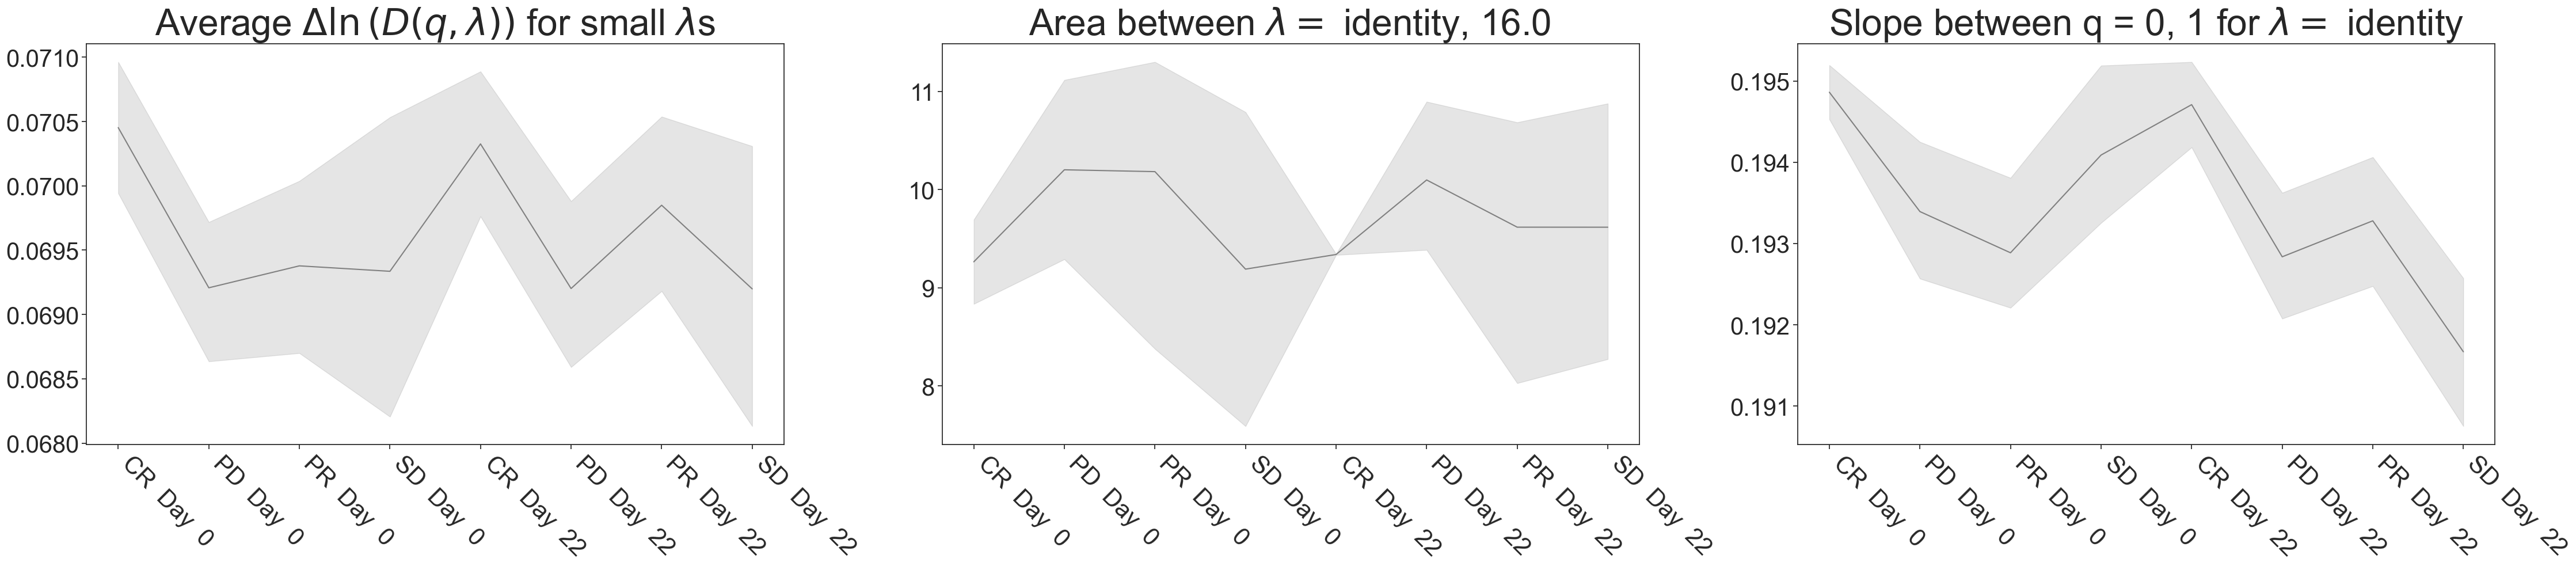

In [31]:
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.rc('axes', labelsize=46) 

fig, ax = plt.subplots(1, 3, figsize=(45, 10), sharey=False, sharex = True)
p1 = sns.lineplot(x="Regime", y="Average area for small lambdas", data=hm_ft_df, sort=False, ax=ax[0], color = "gray")
p2 = sns.lineplot(x="Regime", y="identity_16.0_area", data=hm_ft_df, sort=False, ax=ax[1], color = "gray")
p3 = sns.lineplot(x="Regime", y="0_1_slope_identity", data=hm_ft_df, sort=False, ax=ax[2], color = "gray")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

p1.set_title('Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s', fontsize = 46)
p2.set_title('Area between $\lambda =$ identity, 16.0 ', fontsize = 46)
p3.set_title('Slope between q = 0, 1 for $\lambda =$ identity', fontsize = 46)

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=-45, ha="left")

plt.tight_layout()

plt.savefig(wdir_path + "lineplot_areas_slope.pdf")

### PCA on features 

In [32]:
post_imm_time_df = divP_features["Timepoint"]
treatment_df = divP_features["RECIST criteria"]
sample_names_df = divP_features["sample_name"]

In [33]:
divP_features_treatment_time = divP_features.copy()
divP_features_treatment_time = divP_features.drop(["sample_name",
                                                   "patient",
                                                    "sample_type", 
                                                    "unique_CDR3s"], axis=1)

divP_features_treatment_time

identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.084027            0.466791            9.635807   
1             0.043176            0.443595            8.066101   
2             0.071680            0.572502            9.694778   
3             0.095142            0.532166           10.979845   
4             0.093679            0.688405           11.896086   
5             0.122392            0.638713           11.257728   
6             0.038031            0.369374            8.266225   
7             0.045001            0.339191            7.749877   
8             0.060070            0.394366            8.835639   
9             0.098816            0.441078            8.918239   
10            0.044934            0.325927            6.765512   
11            0.065542            0.339860            6.613901   
12            0.082818            0.674403           11.487570   
13            0.079950            0.655596           11.023552   
14            0.070611            0.591196           10.078921   
15            0.069922            0.570930           10.722913   
16            0.072007            0.488689           10.538634   
17            0.108488            0.659721           11.796141   
18            0.091109            0.647899           11.119738   
19            0.061357            0.629512           11.582040   
20            0.072897            0.588083           11.623830   
21            0.097913            0.432411            9.430210   
22            0.103774            0.468387            9.208456   
23            0.137780            0.684043           11.652764   
24            0.073188            0.543111           10.538923   
25            0.064521            0.435335            9.344788   
26            0.097686            0.381456            6.853433   
27            0.059316            0.590442           10.696146   
28            0.078242            0.335557            7.746102   
29            0.104330            0.675148           11.332423   
30            0.060005            0.463794            9.334767   
31            0.063529            0.429202            8.351762   
32            0.101100            0.628130           11.173110   
33            0.064886            0.423581            8.332572   
34            0.045616            0.441561            8.471166   
35            0.106574            0.609497           10.483853   
36            0.072707            0.583403           10.048429   
37            0.072016            0.583323           11.178222   
38            0.064752            0.576817            9.703428   
39            0.092592            0.475359           10.150440   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           33.460736          50.004947          59.105780   
1           31.157870          47.757955          56.902793   
2           33.817955          50.595438          59.813213   
3           35.312140          52.097670          61.329959   
4           36.399895          52.879366          61.902031   
5           35.616605          52.414498          61.640191   
6           31.843059          48.466856          57.600036   
7           30.272115          47.092874          56.436950   
8           32.809905          49.837455          59.199188   
9           32.460005          48.881557          57.885351   
10          29.770370          46.740098          56.091847   
11          29.790653          46.646261          55.916941   
12          35.669790          52.091205          61.100841   
13          34.792474          51.151285          60.168221   
14          33.009014          49.085071          57.952091   
15          34.359460          50.568989          59.473127   
16          34.996743          51.706930          60.872323   
17          35.994236          52.451295          61.496489   
18          35.096210          51.651615          60.773986   
19          35.894284          52.680

In [34]:
divP_features_treatment_time.shape

(40, 187)

In [35]:
observables = [col for col in list(divP_features_treatment_time) if col != "RECIST criteria"]
observables = [obs for obs in observables if obs != "Timepoint"]
# Separating out the features
x = divP_features_treatment_time.loc[:, observables].values
# Separating out the target
y = divP_features_treatment_time.loc[:,'RECIST criteria'].values

In [36]:
x.shape

(40, 185)

In [37]:
x.mean(), x.std()

(20.88757449832756, 26.10765104394521)

In [38]:
x_scaled = StandardScaler().fit_transform(x)

In [39]:
x_scaled.mean(), x_scaled.std()

(-5.263057257277093e-16, 1.0)

In [40]:
pca_scaled = decomposition.PCA(n_components=26)
principalComponents_scaled = pca_scaled.fit_transform(x_scaled)

principalDf_scaled = pd.DataFrame(data = principalComponents_scaled)
principalDf_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_scaled)]
finalDf_scaled = pd.concat([principalDf_scaled, divP_features_treatment_time[["RECIST criteria", "Timepoint"]]], axis = 1)



In [41]:
def plotPCA(pca_scaled, colour_category, style_category, final_Df, wdir_path, fig_name, legend):
    """
    INPUT:  pca_scaled: pca object
            colour_category: string denoting a categorical var to colour by
            style_category: string denoting a categorical var for the point shape 
            final_Df: DataFrame with principal components and categorical variables
            wdir_path: path to working directory
            fig_name: string for figure name, ending with the extension pdf or png
            legend: True or False
            
    OUTPUT: 
            PCA figure with the aspect ratio corresponding to the principal components values 
    """
    per_PC1 = int(round(pca_scaled.explained_variance_ratio_[0]*100, 0))
    per_PC2 = int(round(pca_scaled.explained_variance_ratio_[1]*100, 0))
    if per_PC1 != 0 and per_PC2 != 0:
        fig, ax = plt.subplots(figsize=(per_PC1/5,per_PC2/5))
    else: 
        fig, ax = plt.subplots(figsize=(20,1))
    cmap = sns.color_palette("colorblind", len(list(set(final_Df[colour_category]))))
    if legend == True: 
        legend_box = "full"
    else: 
        legend_box = False
    p = sns.scatterplot(x="PC_0", y="PC_1",
                     hue=colour_category, style = style_category,
                     palette=cmap, s=100,
                     data=final_Df, 
                     alpha = 1, legend = legend_box)
    if legend == True: 
        p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tick_params(axis='both',          # changes apply which axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    left = False,
                    right = False,
                    labelbottom=False,
                    labelleft = False) # labels along the bottom edge are off
    #plt.xticks(fontsize = 13)
    #plt.yticks(fontsize = 13)
    plt.xlabel("".join(["PC1 (",str(per_PC1),"%)"]), fontsize = 15)
    plt.ylabel("".join(["PC2 (",str(per_PC2),"%)"]), fontsize = 15)
    plt.tight_layout()
    plt.savefig(wdir_path + fig_name, bbox_inches='tight')

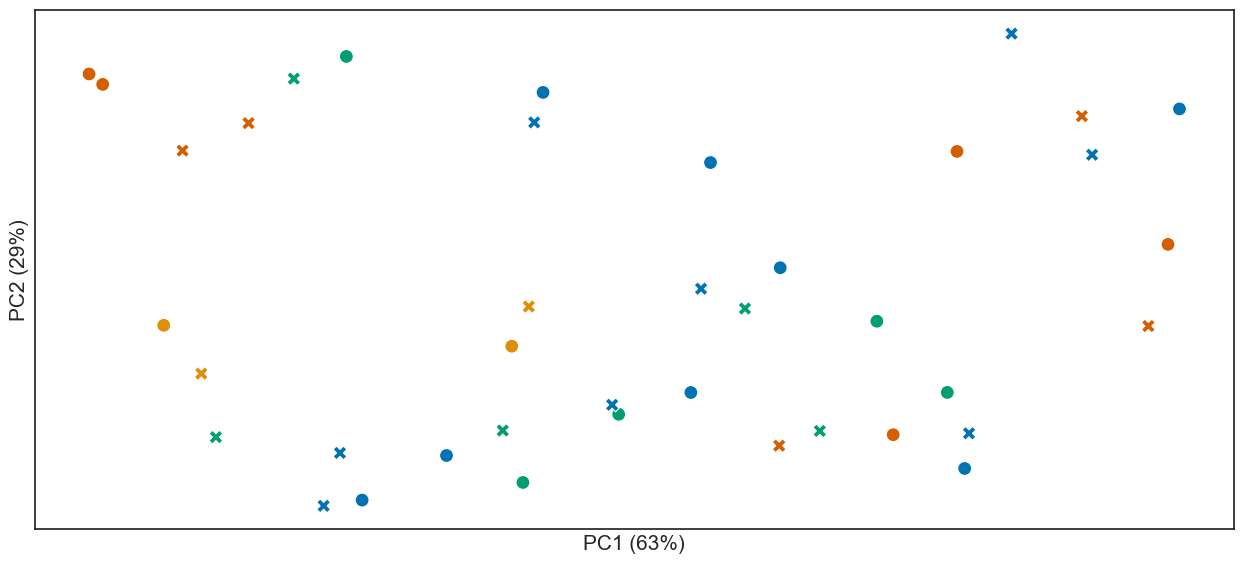

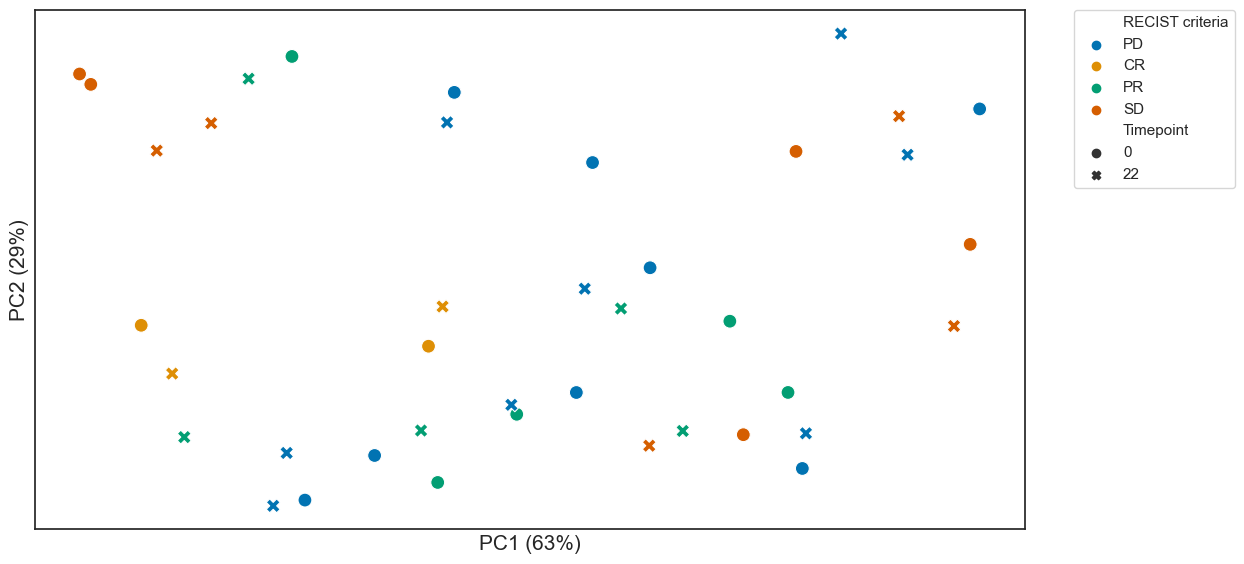

In [42]:
plotPCA(pca_scaled, "RECIST criteria", "Timepoint", 
        finalDf_scaled, wdir_path, "PCA_features.pdf", False)


plotPCA(pca_scaled,  "RECIST criteria", "Timepoint", 
        finalDf_scaled, wdir_path, "PCA_features_w_legend.pdf", True)




### PCA on $D(q,\lambda)$

In [43]:
post_imm_time_divP1_all_df = divP1_all_df["Timepoint"]
treatment_divP1_all_df = divP1_all_df["RECIST criteria"]
sample_names_divP1_all_df = divP1_all_df["sample_name"]

In [44]:

divP1_all_df_treatment_time = divP1_all_df.copy()
divP1_all_df_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "patient", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                ], axis=1)
divP1_all_df_treatment_time

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.070843  0.070831   0.07082  0.070808  0.070796  0.070785  0.070773   
1    0.07102   0.07101     0.071   0.07099   0.07098  0.070971  0.070961   
2   0.071597  0.071587  0.071576  0.071565  0.071555  0.071544  0.071534   
3   0.071664  0.071654  0.071644  0.071634  0.071624  0.071615  0.071605   
4   0.070138  0.070126  0.070114  0.070102  0.070091  0.070079  0.070067   
5   0.071628  0.071618  0.071607  0.071597  0.071586  0.071576  0.071565   
6   0.070993  0.070981   0.07097  0.070958  0.070947  0.070935  0.070924   
7   0.072588   0.07258  0.072571  0.072563  0.072554  0.072546  0.072537   
8   0.072543  0.072534  0.072524  0.072515  0.072505  0.072496  0.072486   
9   0.069939  0.069927  0.069915  0.069904  0.069892   0.06988  0.069869   
10    0.0725  0.072491  0.072483  0.072474  0.072465  0.072456  0.072448   
11  0.071982  0.071972  0.071961  0.071951  0.071941  0.071931  0.071921   
12  0.070055  0.070044  0.070033  0.070021   0.07001  0.069999  0.069988   
13  0.070289  0.070278  0.070267  0.070256  0.070245  0.070234  0.070224   
14  0.069154  0.069142   0.06913  0.069119  0.069107  0.069095  0.069084   
15  0.069343  0.069331  0.069319  0.069307  0.069295  0.069283  0.069271   
16  0.071173  0.071163  0.071152  0.071141  0.071131   0.07112   0.07111   
17  0.070335  0.070324  0.070313  0.070301   0.07029  0.070279  0.070268   
18   0.07104  0.071029  0.071018  0.071008  0.070997  0.070986  0.070976   
19  0.071845  0.071836  0.071827  0.071817  0.071808  0.071799   0.07179   
20  0.070662  0.070651   0.07064   0.07063  0.070619  0.070608  0.070597   
21  0.072614  0.072604  0.072594  0.072584  0.072574  0.072564  0.072554   
22  0.069454  0.069442  0.069431  0.069419  0.069407  0.069396  0.069384   
23  0.070028  0.070016  0.070004  0.069993  0.069981   0.06997  0.069958   
24  0.071982  0.071972  0.071963  0.071953  0.071944  0.071934  0.071924   
25  0.072444  0.072434  0.072425  0.072415  0.072406  0.072396  0.072387   
26  0.072002  0.071992  0.071982  0.071972  0.071963  0.071953  0.071943   
27  0.071265  0.071254  0.071243  0.071233  0.071222  0.071212  0.071201   
28  0.072242  0.072233  0.072224  0.072215  0.072206  0.072198  0.072189   
29  0.071945  0.071936  0.071927  0.071917  0.071908  0.071899   0.07189   
30  0.071376  0.071366  0.071355  0.071345  0.071334  0.071324  0.071313   
31  0.071108  0.071098  0.071088  0.071078  0.071068  0.071059  0.071049   
32  0.070547  0.070536  0.070525  0.070514  0.070503  0.070491   0.07048   
33  0.072092  0.072083  0.072074  0.072066  0.072057  0.072048  0.072039   
34  0.069673  0.069662   0.06965  0.069639  0.069627  0.069616  0.069604   
35  0.070682  0.070671  0.070661   0.07065   0.07064  0.070629  0.070619   
36  0.069554  0.069543  0.069531  0.069519  0.069508  0.069496  0.069485   
37  0.069604  0.069592   0.06958  0.069568  0.069555  0.069543  0.069531   
38  0.071106  0.071095  0.071083  0.071072  0.071061  0.071049  0.071038   
39  0.071562  0.071552  0.071541   0.07153   0.07152  0.071509  0.071499   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_0 L_identity_q_1  \
0    0.060464  0.141598  0.141551  ...      10.159989       9.966514   
1    0.061154  0.141946  0.141907  ...       9.849137       9.657522   
2    0.061051  0.143106  0.143064  ...      10.277634      10.083106   
3    0.061224  0.143235  0.143196  ...      10.494325      10.302159   
4    0.059776  0.140191  0.140144  ...      10.549307      10.353779   
5    0.061261  0.143167  0.143125  ...      10.537362      10.345233   
6     0.06039  0.141899  0.141852  ...       9.947744       9.755701   
7    0.063097  0.145073  0.145039  ...       9.813946       9.620902   
8    0.062519  0.144991  0.144953  ...      10.211303      10.016109   
9      0.0598  0.139795  0.139748  ...        9.96979        9.77575   
10   0.062525  0.144902  0.144866  ...       9.765546       9.569595   
11   0.061846  0.14387

In [45]:
divP1_all_df_treatment_time.shape

(40, 130)

In [46]:
observables = [col for col in list(divP1_all_df_treatment_time) if col != "RECIST criteria"]
observables = [obs for obs in observables if obs != "Timepoint"]
# Separating out the features
x_qDZ = divP1_all_df_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ = divP1_all_df_treatment_time.loc[:,'RECIST criteria'].values

In [47]:
x_qDZ.shape

(40, 128)

In [48]:
x_qDZ.mean(), x_qDZ.std()

(3.1496274581566324, 3.8621434593019726)

In [49]:
x_qDZ_scaled = StandardScaler().fit_transform(x_qDZ)

In [50]:
x_qDZ_scaled.mean(), x_qDZ_scaled.std()

(-1.9411555696180472e-16, 1.0)

In [51]:
pca_qDZ_scaled = decomposition.PCA(n_components=26)
principalComponents_qDZ_scaled = pca_qDZ_scaled.fit_transform(x_qDZ_scaled)

principalDf_qDZ_scaled = pd.DataFrame(data = principalComponents_qDZ_scaled)
principalDf_qDZ_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_scaled)]
finalDf_qDZ_scaled = pd.concat([principalDf_qDZ_scaled, divP1_all_df_treatment_time[["RECIST criteria", "Timepoint"]]], axis = 1)



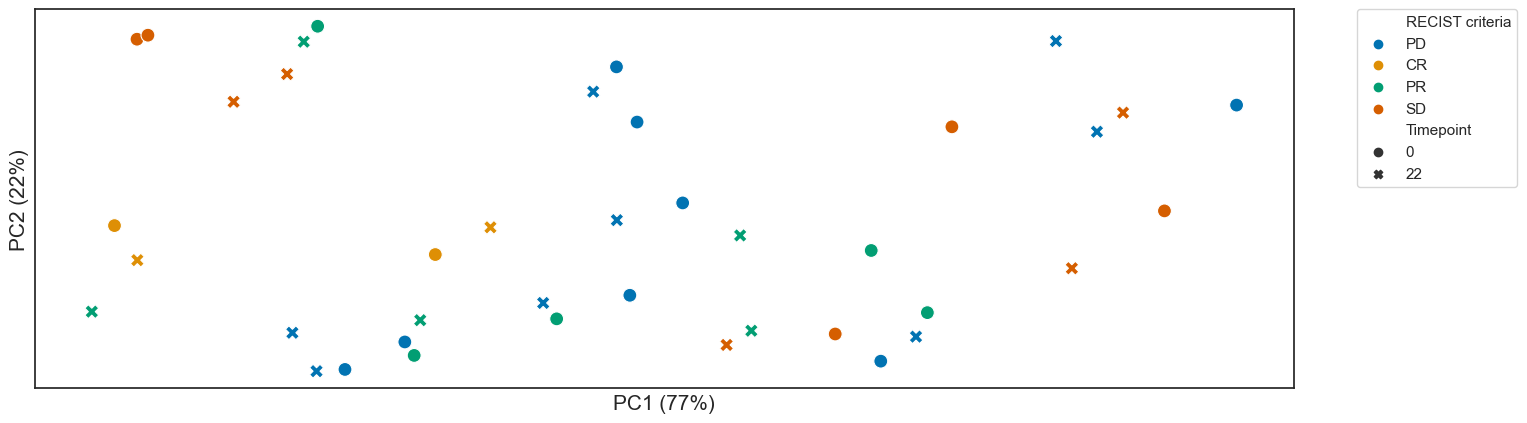

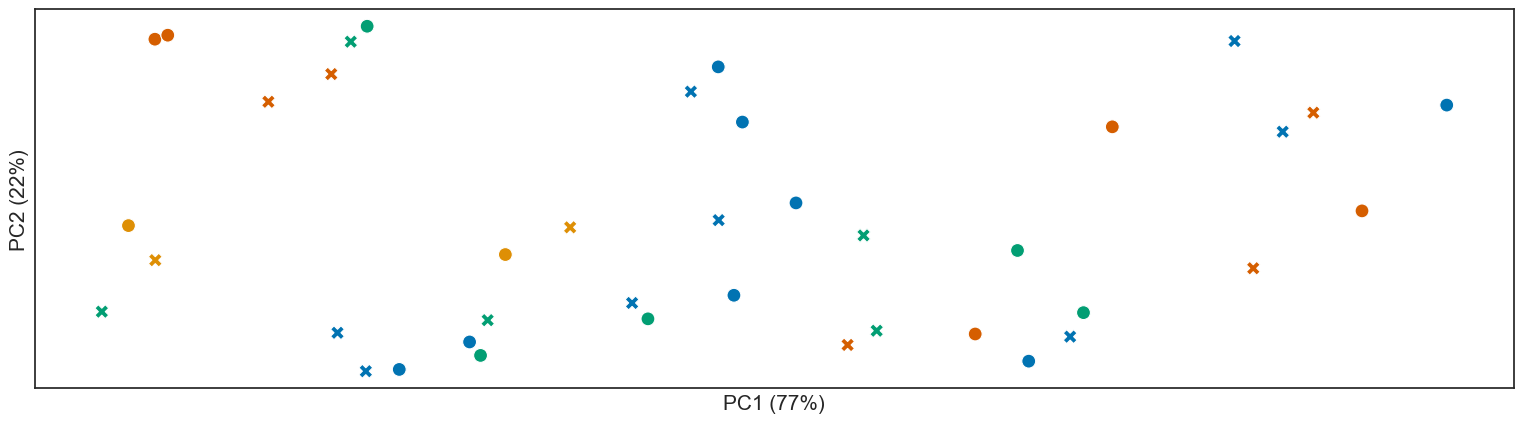

In [52]:
plotPCA(pca_qDZ_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ_w_legend.pdf", True)

plotPCA(pca_qDZ_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ.pdf", False)





### PCA on identity qD

In [53]:
col_without_identity = [colname for colname in list(divP1_all_df) if "L" in colname] 
col_without_identity = [colname for colname in col_without_identity if "identity" not in colname] 

In [54]:
divP1_identity_treatment_time = divP1_all_df.copy()
divP1_identity_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "patient", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                  ] + col_without_identity, axis=1)









divP1_identity_treatment_time



L_identity_q_0 L_identity_q_1 L_identity_q_2 L_identity_q_3 L_identity_q_4  \
0       10.159989       9.966514       9.871815       9.813016       9.771977   
1        9.849137       9.657522       9.562953       9.503785       9.462426   
2       10.277634      10.083106       9.988548       9.929665       9.888512   
3       10.494325      10.302159      10.207861      10.148853      10.107493   
4       10.549307      10.353779      10.258231      10.198727      10.157226   
5       10.537362      10.345233      10.250864      10.191994       10.15082   
6        9.947744       9.755701       9.660606        9.60112       9.559559   
7        9.813946       9.620902       9.526864       9.468216       9.427236   
8       10.211303      10.016109       9.921052        9.86198       9.820741   
9         9.96979        9.77575       9.681035       9.621998       9.580777   
10       9.765546       9.569595       9.475216       9.416931       9.376397   
11       9.726333       9.533579        9.43995       9.381551       9.340686   
12      10.428926      10.236104      10.141749      10.082977      10.041894   
13      10.301794      10.107099      10.012111       9.953203       9.912165   
14       9.962275       9.768081        9.67342        9.61457       9.573485   
15      10.181914       9.988845       9.894586       9.835838       9.794753   
16      10.417687      10.225656      10.131646      10.073051      10.032109   
17      10.493328      10.298992      10.203976      10.144912      10.103661   
18      10.404202      10.209306      10.114168      10.054917      10.013567   
19      10.585447      10.392221      10.297332      10.238085      10.196628   
20       10.50723      10.313987      10.219304      10.160307      10.119077   
21      10.392926      10.199753      10.105554      10.046995      10.006132   
22        9.93639       9.743949       9.650098       9.591868       9.551257   
23      10.491774      10.298862      10.203127      10.143337      10.101619   
24      10.471468      10.278095      10.183626      10.124712       10.08351   
25      10.299979      10.105796      10.010171       9.950569       9.908983   
26       9.772752       9.579707       9.485322       9.426382        9.38511   
27      10.403748      10.209258      10.114475      10.055515      10.014345   
28       9.917933       9.726438       9.631981       9.573139       9.532056   
29      10.581952      10.389744      10.295232      10.236289      10.195079   
30      10.207879      10.012646       9.917328       9.858147        9.81693   
31       9.904587       9.713754       9.619885       9.561299       9.520258   
32      10.464873      10.272991      10.178928      10.120114      10.078899   
33       9.895909       9.705002       9.611341       9.552857       9.511942   
34       9.781263       9.588695       9.494598       9.436203       9.395471   
35      10.258992      10.065302       9.971064       9.912598       9.871837   
36      10.019803       9.827584       9.734161       9.675844       9.634995   
37      10.313808      10.123549      10.030425       9.972173       9.931371   
38      10.193804       9.999713       9.905318       9.846758       9.805902   
39      10.421329      10.226721      10.131827      10.072875      10.031776   

   L_identity_q_5 L_identity_q_6 L_identity_q_11 RECIST criteria  Timepoint  
0        9.741266       9.717195        9.465169              PD          0  
1        9.431526        9.40737        9.157773              PD          0  
2         9.85772       9.833605        9.584145              CR          0  
3       10.076478       10.05215        9.799338              PD          0  
4       10.126257      10.102067         9.85261              PD          0  
5       10.119998      10.095852        9.844281              PR          0  
6        9.528519       9.504263         9.25546              PD          0  
7        9.396605       9.372651        9.125563         

In [55]:
observables = [col for col in list(divP1_identity_treatment_time) if col != "RECIST criteria"]
observables = [obs for obs in observables if obs != "Timepoint"]
# Separating out the features
x_qDZ_identity1 = divP1_identity_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ_identity1 = divP1_identity_treatment_time.loc[:,'RECIST criteria'].values

In [56]:
x_qDZ_identity1.shape

(40, 8)

In [57]:
x_qDZ_identity1.mean(), x_qDZ_identity1.std()

(9.861828082820903, 0.3284941933130528)

In [58]:
x_qDZ_identity1_scaled = StandardScaler().fit_transform(x_qDZ_identity1)

In [59]:
x_qDZ_identity1_scaled.mean(), x_qDZ_identity1_scaled.std()

(3.066991105526995e-16, 1.0)

In [60]:
pca_qDZ_identity1_scaled = decomposition.PCA(n_components=8)
principalComponents_qDZ_identity1_scaled = pca_qDZ_identity1_scaled.fit_transform(x_qDZ_identity1_scaled)

principalDf_qDZ_identity1_scaled = pd.DataFrame(data = principalComponents_qDZ_identity1_scaled)
principalDf_qDZ_identity1_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_identity1_scaled)]
finalDf_qDZ_identity1_scaled = pd.concat([principalDf_qDZ_identity1_scaled, divP1_identity_treatment_time[["RECIST criteria", "Timepoint"]]], axis = 1)



/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50343/2086500981.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


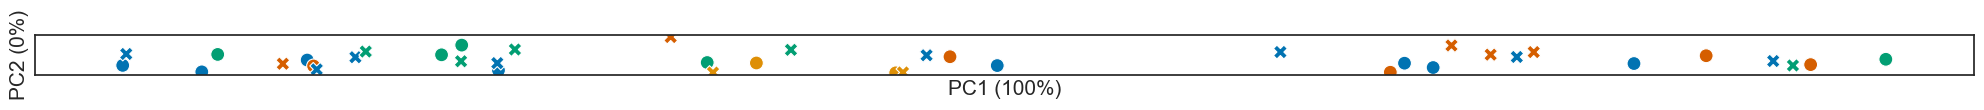

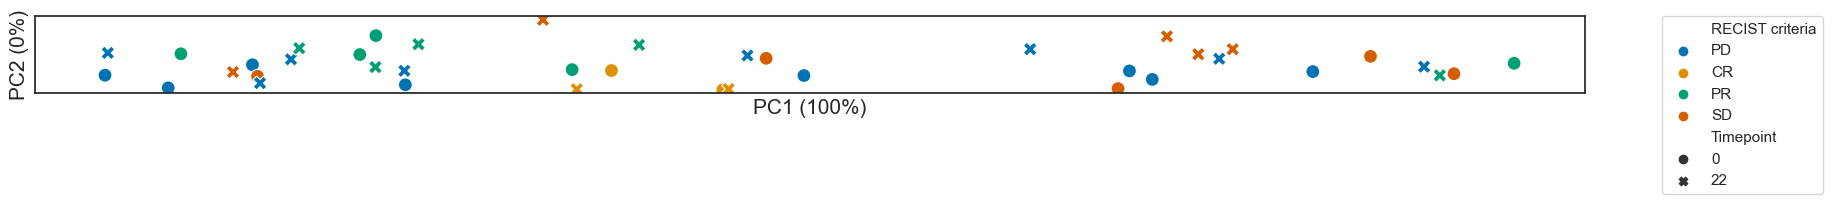

In [61]:
plotPCA(pca_qDZ_identity1_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity.pdf", False)

plotPCA(pca_qDZ_identity1_scaled, "RECIST criteria", "Timepoint", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity_w_legend.pdf", True)






### Exp(Shannon index) separation 

In [62]:
divP1_identity_q1_treatment_time = divP1_all_df[["L_identity_q_1", "Timepoint", "RECIST criteria"]]

divP1_identity_q1_treatment_time



L_identity_q_1  Timepoint RECIST criteria
0        9.966514          0              PD
1        9.657522          0              PD
2       10.083106          0              CR
3       10.302159          0              PD
4       10.353779          0              PD
5       10.345233          0              PR
6        9.755701          0              PD
7        9.620902          0              SD
8       10.016109          0              CR
9         9.77575          0              SD
10       9.569595          0              SD
11       9.533579          0              PR
12      10.236104          0              PR
13      10.107099          0              PR
14       9.768081          0              PD
15       9.988845          0              SD
16      10.225656          0              PR
17      10.298992          0              SD
18      10.209306          0              PD
19      10.392221          0              PD
20      10.313987         22              SD
21      10.199753         22              PR
22       9.743949         22              SD
23      10.298862         22              PD
24      10.278095         22              PD
25      10.105796         22              CR
26       9.579707         22              PR
27      10.209258         22              PD
28       9.726438         22              SD
29      10.389744         22              PD
30      10.012646         22              CR
31       9.713754         22              PD
32      10.272991         22              PR
33       9.705002         22              SD
34       9.588695         22              PD
35      10.065302         22              PR
36       9.827584         22              PD
37      10.123549         22              SD
38       9.999713         22              PD
39      10.226721         22              PR

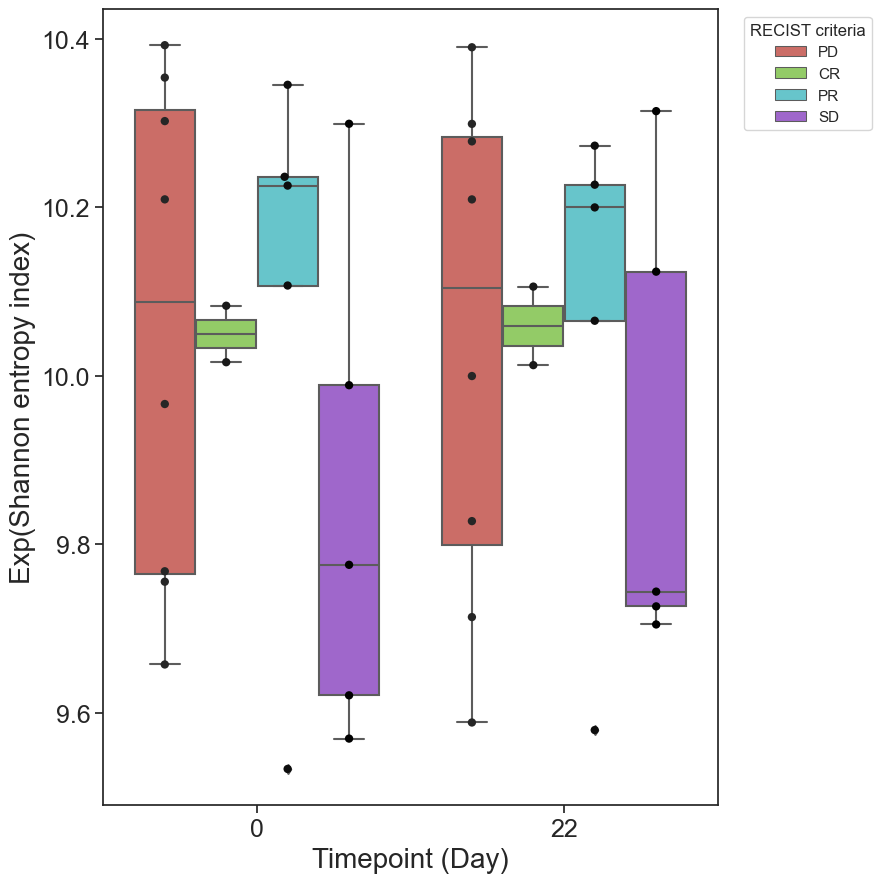

In [63]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q1_treatment_time["RECIST criteria"]))))
p = sns.boxplot(x="Timepoint", y="L_identity_q_1", hue="RECIST criteria",
                 data=divP1_identity_q1_treatment_time, palette=cmap)
p = sns.swarmplot(x="Timepoint", y="L_identity_q_1", hue="RECIST criteria",data=divP1_identity_q1_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)

# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q1_treatment_time["RECIST criteria"])))], labels[0:len(list(set(divP1_identity_q1_treatment_time["RECIST criteria"])))], 
                   title = "RECIST criteria", loc=2, bbox_to_anchor=(1.03, 1))


plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Timepoint (Day)", fontsize = 20)
plt.ylabel("Exp(Shannon entropy index)", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Exp_Shannon_entropy_barplot.pdf")

### Gini analogue separation

In [64]:
divP1_identity_q2_treatment_time = divP1_all_df[["L_identity_q_2", "Timepoint", "RECIST criteria"]]

divP1_identity_q2_treatment_time



L_identity_q_2  Timepoint RECIST criteria
0        9.871815          0              PD
1        9.562953          0              PD
2        9.988548          0              CR
3       10.207861          0              PD
4       10.258231          0              PD
5       10.250864          0              PR
6        9.660606          0              PD
7        9.526864          0              SD
8        9.921052          0              CR
9        9.681035          0              SD
10       9.475216          0              SD
11        9.43995          0              PR
12      10.141749          0              PR
13      10.012111          0              PR
14        9.67342          0              PD
15       9.894586          0              SD
16      10.131646          0              PR
17      10.203976          0              SD
18      10.114168          0              PD
19      10.297332          0              PD
20      10.219304         22              SD
21      10.105554         22              PR
22       9.650098         22              SD
23      10.203127         22              PD
24      10.183626         22              PD
25      10.010171         22              CR
26       9.485322         22              PR
27      10.114475         22              PD
28       9.631981         22              SD
29      10.295232         22              PD
30       9.917328         22              CR
31       9.619885         22              PD
32      10.178928         22              PR
33       9.611341         22              SD
34       9.494598         22              PD
35       9.971064         22              PR
36       9.734161         22              PD
37      10.030425         22              SD
38       9.905318         22              PD
39      10.131827         22              PR

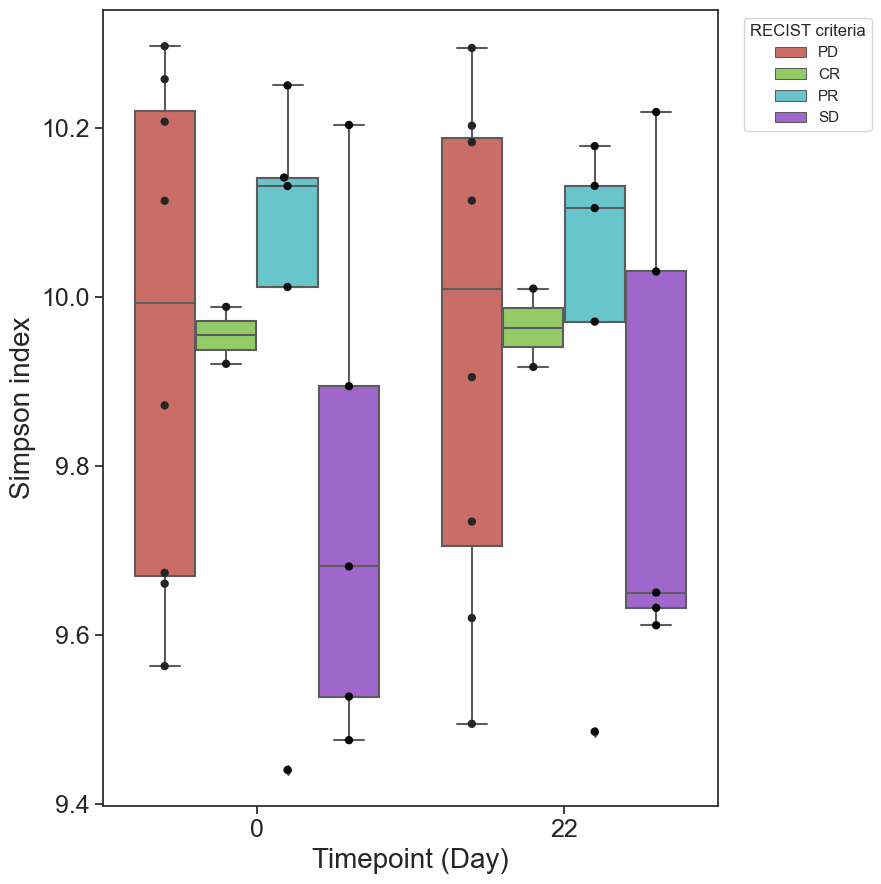

In [65]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q2_treatment_time["RECIST criteria"]))))
p = sns.boxplot(x="Timepoint", y="L_identity_q_2", hue="RECIST criteria",
                 data=divP1_identity_q2_treatment_time, palette=cmap)
p = sns.swarmplot(x="Timepoint", y="L_identity_q_2", hue="RECIST criteria",data=divP1_identity_q2_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)
# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q2_treatment_time["RECIST criteria"])))], labels[0:len(list(set(divP1_identity_q2_treatment_time["RECIST criteria"])))], 
                   title = "RECIST criteria", loc=2, bbox_to_anchor=(1.03, 1))


#p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Timepoint (Day)", fontsize = 20)
plt.ylabel("Simpson index", fontsize = 20)

plt.tight_layout()
plt.savefig(wdir_path + "Gini_Simpson_index_barplot.pdf")

### Shannon vs Gini-Simpson 

In [66]:
divP_Shannon_Gini = divP1_identity_q2_treatment_time.copy()
divP_Shannon_Gini["L_identity_q_1"] = divP1_identity_q1_treatment_time["L_identity_q_1"]
divP_Shannon_Gini

L_identity_q_2  Timepoint RECIST criteria L_identity_q_1
0        9.871815          0              PD       9.966514
1        9.562953          0              PD       9.657522
2        9.988548          0              CR      10.083106
3       10.207861          0              PD      10.302159
4       10.258231          0              PD      10.353779
5       10.250864          0              PR      10.345233
6        9.660606          0              PD       9.755701
7        9.526864          0              SD       9.620902
8        9.921052          0              CR      10.016109
9        9.681035          0              SD        9.77575
10       9.475216          0              SD       9.569595
11        9.43995          0              PR       9.533579
12      10.141749          0              PR      10.236104
13      10.012111          0              PR      10.107099
14        9.67342          0              PD       9.768081
15       9.894586          0              SD       9.988845
16      10.131646          0              PR      10.225656
17      10.203976          0              SD      10.298992
18      10.114168          0              PD      10.209306
19      10.297332          0              PD      10.392221
20      10.219304         22              SD      10.313987
21      10.105554         22              PR      10.199753
22       9.650098         22              SD       9.743949
23      10.203127         22              PD      10.298862
24      10.183626         22              PD      10.278095
25      10.010171         22              CR      10.105796
26       9.485322         22              PR       9.579707
27      10.114475         22              PD      10.209258
28       9.631981         22              SD       9.726438
29      10.295232         22              PD      10.389744
30       9.917328         22              CR      10.012646
31       9.619885         22              PD       9.713754
32      10.178928         22              PR      10.272991
33       9.611341         22              SD       9.705002
34       9.494598         22              PD       9.588695
35       9.971064         22              PR      10.065302
36       9.734161         22              PD       9.827584
37      10.030425         22              SD      10.123549
38       9.905318         22              PD       9.999713
39      10.131827         22              PR      10.226721

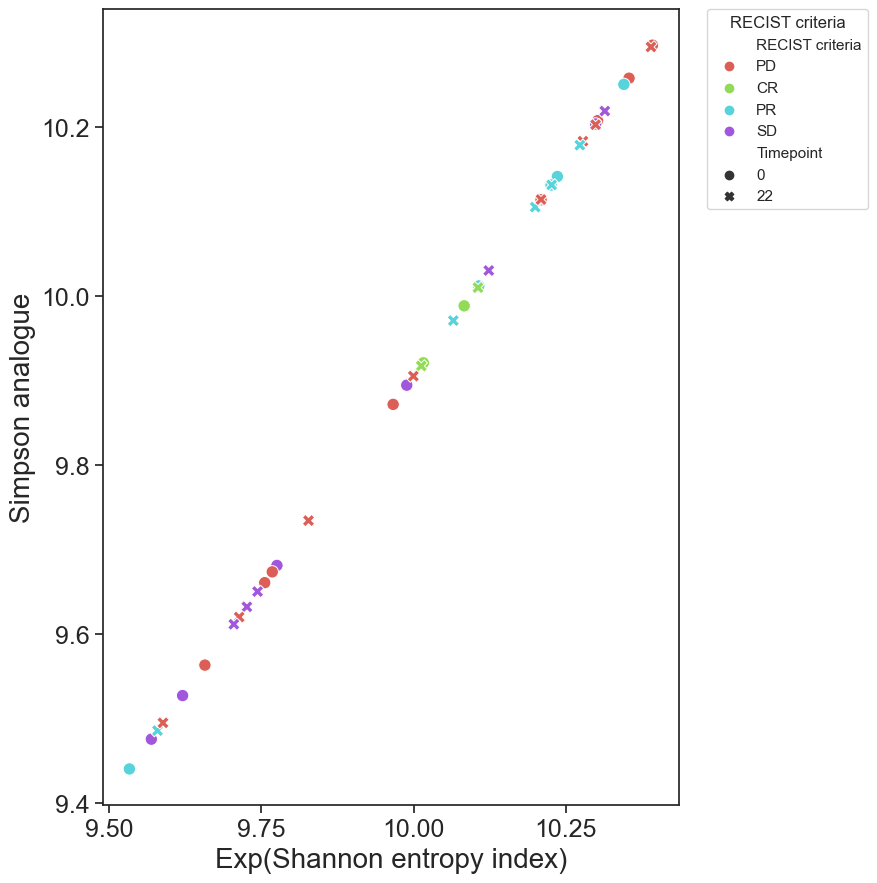

In [67]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP_Shannon_Gini["RECIST criteria"]))))
p = sns.scatterplot(x="L_identity_q_1", y="L_identity_q_2", 
                     data=divP_Shannon_Gini,
                     hue="RECIST criteria", palette=cmap,  
                     style = "Timepoint", 
                    s = 80
                   )




p.legend(title = "RECIST criteria", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Exp(Shannon entropy index)", fontsize = 20)
plt.ylabel("Simpson analogue", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Shannon_vs_Gini_Simpson_index_scatter_plot.pdf")




# Hierarchical clustering 

## Cluster divP features 

In [68]:
divP_features_HC = divP_features_treatment_time.copy()

divP_features_HC = divP_features_HC.set_index(["RECIST criteria", "Timepoint"])

divP_features_HC

identity_64.0_area  identity_32.0_area  \
RECIST criteria Timepoint                                           
PD              0                    0.084027            0.466791   
                0                    0.043176            0.443595   
CR              0                    0.071680            0.572502   
PD              0                    0.095142            0.532166   
                0                    0.093679            0.688405   
PR              0                    0.122392            0.638713   
PD              0                    0.038031            0.369374   
SD              0                    0.045001            0.339191   
CR              0                    0.060070            0.394366   
SD              0                    0.098816            0.441078   
                0                    0.044934            0.325927   
PR              0                    0.065542            0.339860   
                0                    0.082818            0.674403   
                0                    0.079950            0.655596   
PD              0                    0.070611            0.591196   
SD              0                    0.069922            0.570930   
PR              0                    0.072007            0.488689   
SD              0                    0.108488            0.659721   
PD              0                    0.091109            0.647899   
                0                    0.061357            0.629512   
SD              22                   0.072897            0.588083   
PR              22                   0.097913            0.432411   
SD              22                   0.103774            0.468387   
PD              22                   0.137780            0.684043   
                22                   0.073188            0.543111   
CR              22                   0.064521            0.435335   
PR              22                   0.097686            0.381456   
PD              22                   0.059316            0.590442   
SD              22                   0.078242            0.335557   
PD              22                   0.104330            0.675148   
CR              22                   0.060005            0.463794   
PD              22                   0.063529            0.429202   
PR              22                   0.101100            0.628130   
SD              22                   0.064886            0.423581   
PD              22                   0.045616            0.441561   
PR              22                   0.106574            0.609497   
PD              22                   0.072707            0.583403   
SD              22                   0.072016            0.583323   
PD              22                   0.064752            0.576817   
PR              22                   0.092592            0.475359   

                           identity_16.0_area  identity_8.0_area  \
RECIST criteria Timepoint                                          
PD              0                    9.635807          33.460736   
                0                    8.066101          31.157870   
CR              0                    9.694778          33.817955   
PD              0                   10.979845          35.312140   
                0                   11.896086          36.399895   
PR              0                   11.257728          35.616605   
PD              0                    8.266225          31.843059   
SD              0                    7.749877          30.272115   
CR              0                    8.835639          32.809905   
SD              0                    8.918239          32.460005   
                0                    6.765512          29.770370   
PR              0                    6.613901          29.790653   
                0                   11.487570          35.669790   
                0                   11.023552          34.792474   
PD              0                   10.0

<Figure size 600x800 with 0 Axes>

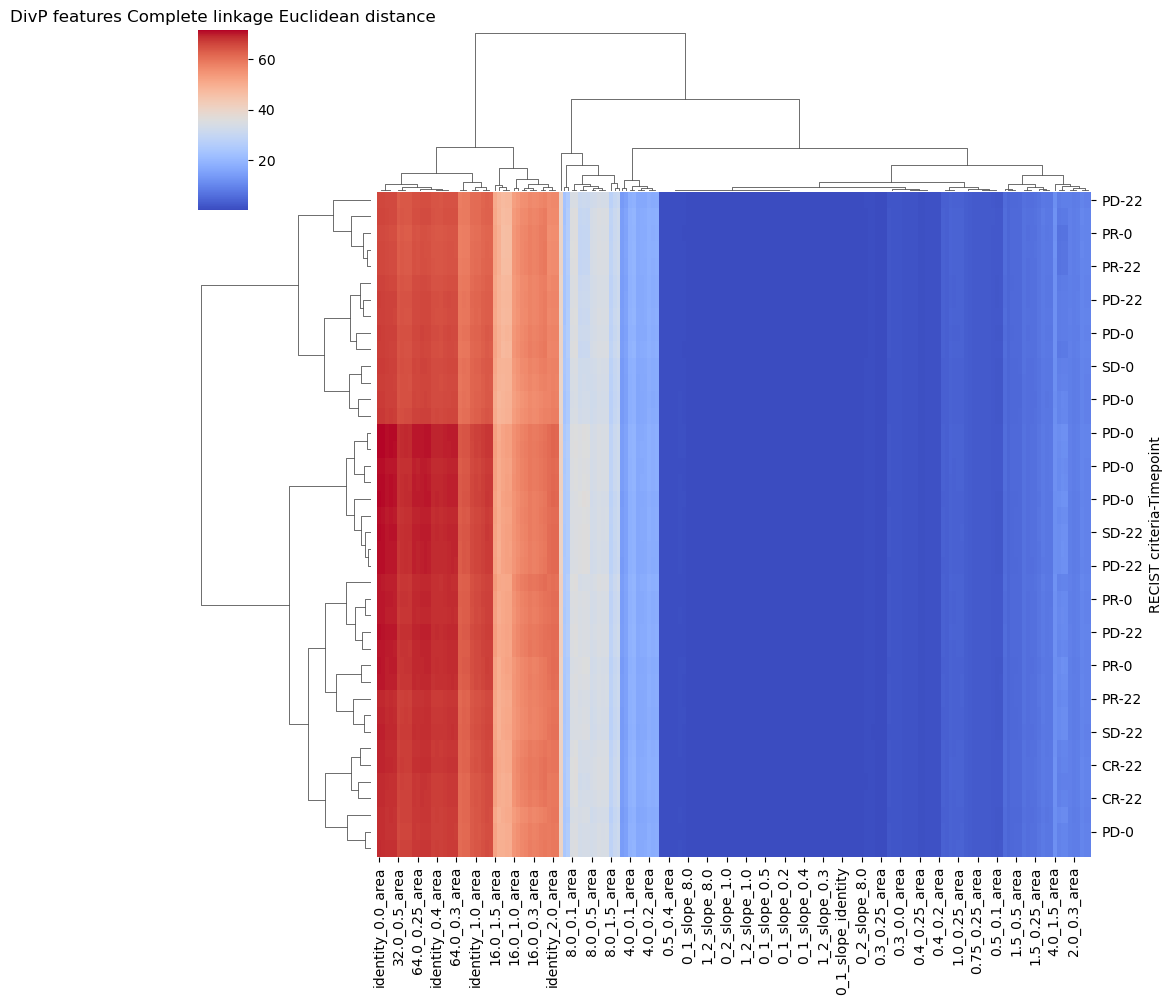

In [69]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_features_HC,
               method='complete',
                metric='euclidean',
              cmap="coolwarm")
if not os.path.isdir(wdir_path+"heatmaps/"):
    os.makedirs(wdir_path+"heatmaps/", exist_ok=False)

plt.title("DivP features Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_divP_features.png", bbox_inches='tight')


## Cluster true diversity

In [70]:
divP_qDZ_HC = divP1_all_df.copy()

divP_qDZ_HC = divP_qDZ_HC.set_index(["RECIST criteria", "Timepoint"])

divP_qDZ_HC = divP_qDZ_HC.drop(["unique_CDR3s", "patient", "sample_name", "sample_type"], axis = 1)
divP_qDZ_HC

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4  \
RECIST criteria Timepoint                                                     
PD              0          0.070843  0.070831   0.07082  0.070808  0.070796   
                0           0.07102   0.07101     0.071   0.07099   0.07098   
CR              0          0.071597  0.071587  0.071576  0.071565  0.071555   
PD              0          0.071664  0.071654  0.071644  0.071634  0.071624   
                0          0.070138  0.070126  0.070114  0.070102  0.070091   
PR              0          0.071628  0.071618  0.071607  0.071597  0.071586   
PD              0          0.070993  0.070981   0.07097  0.070958  0.070947   
SD              0          0.072588   0.07258  0.072571  0.072563  0.072554   
CR              0          0.072543  0.072534  0.072524  0.072515  0.072505   
SD              0          0.069939  0.069927  0.069915  0.069904  0.069892   
                0            0.0725  0.072491  0.072483  0.072474  0.072465   
PR              0          0.071982  0.071972  0.071961  0.071951  0.071941   
                0          0.070055  0.070044  0.070033  0.070021   0.07001   
                0          0.070289  0.070278  0.070267  0.070256  0.070245   
PD              0          0.069154  0.069142   0.06913  0.069119  0.069107   
SD              0          0.069343  0.069331  0.069319  0.069307  0.069295   
PR              0          0.071173  0.071163  0.071152  0.071141  0.071131   
SD              0          0.070335  0.070324  0.070313  0.070301   0.07029   
PD              0           0.07104  0.071029  0.071018  0.071008  0.070997   
                0          0.071845  0.071836  0.071827  0.071817  0.071808   
SD              22         0.070662  0.070651   0.07064   0.07063  0.070619   
PR              22         0.072614  0.072604  0.072594  0.072584  0.072574   
SD              22         0.069454  0.069442  0.069431  0.069419  0.069407   
PD              22         0.070028  0.070016  0.070004  0.069993  0.069981   
                22         0.071982  0.071972  0.071963  0.071953  0.071944   
CR              22         0.072444  0.072434  0.072425  0.072415  0.072406   
PR              22         0.072002  0.071992  0.071982  0.071972  0.071963   
PD              22         0.071265  0.071254  0.071243  0.071233  0.071222   
SD              22         0.072242  0.072233  0.072224  0.072215  0.072206   
PD              22         0.071945  0.071936  0.071927  0.071917  0.071908   
CR              22         0.071376  0.071366  0.071355  0.071345  0.071334   
PD              22         0.071108  0.071098  0.071088  0.071078  0.071068   
PR              22         0.070547  0.070536  0.070525  0.070514  0.070503   
SD              22         0.072092  0.072083  0.072074  0.072066  0.072057   
PD              22         0.069673  0.069662   0.06965  0.069639  0.069627   
PR              22         0.070682  0.070671  0.070661   0.07065   0.07064   
PD              22         0.069554  0.069543  0.069531  0.069519  0.069508   
SD              22         0.069604  0.069592   0.06958  0.069568  0.069555   
PD              22         0.071106  0.071095  0.071083  0.071072  0.071061   
PR              22         0.071562  0.071552  0.071541   0.07153   0.07152   

                          L_0.1_q_5 L_0.1_q_6 L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  \
RECIST criteria Timepoint                                                      
PD              0          0.070785  0.070773   0.060464  0.141598  0.141551   
                0          0.070971  0.070961   0.061154  0.141946  0.141907   
CR              0          0.071544  0.071534   0.061051  0.143106  0.143064   
PD              0          0.071615  0.071605   0.061224  0.143235  0.143196   
                0          0.070079  0.070067   0.059776  0.140191  0.140144   
PR              0          0.071576  0.071565   0.061261  0.143167  0.143125   
PD              0          0.070935  0.070924    0.06039  0.141899 

In [71]:
divP_qDZ_HC.isnull().values.any()

False

In [72]:
divP_qDZ_HC = divP_qDZ_HC.apply(pd.to_numeric) 

In [73]:
divP_qDZ_HC.dtypes

L_0.1_q_0          float64
L_0.1_q_1          float64
L_0.1_q_2          float64
L_0.1_q_3          float64
L_0.1_q_4          float64
                    ...   
L_identity_q_3     float64
L_identity_q_4     float64
L_identity_q_5     float64
L_identity_q_6     float64
L_identity_q_11    float64
Length: 128, dtype: object

<Figure size 600x800 with 0 Axes>

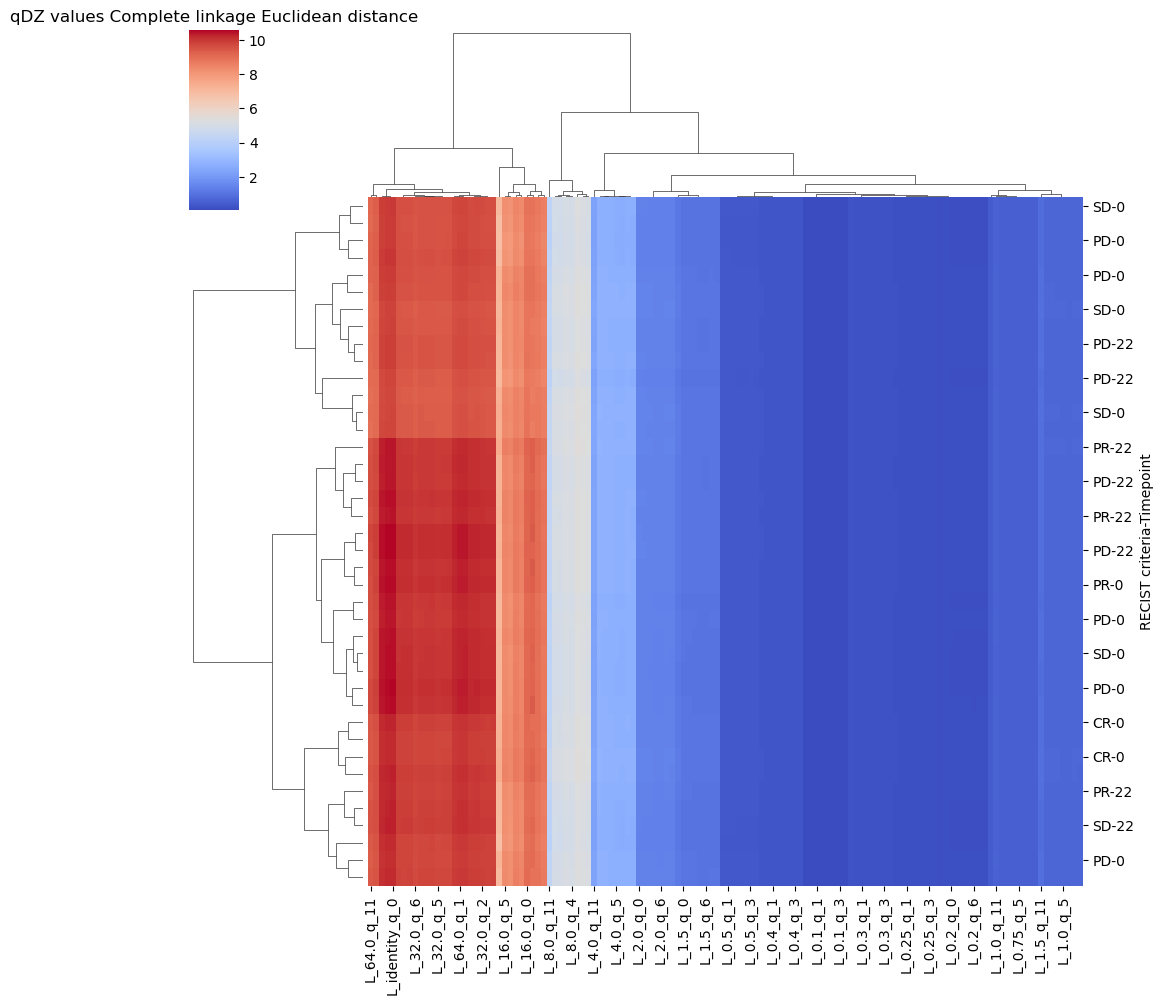

In [74]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_qDZ_HC,
               method='complete',
                metric='euclidean',
                cmap="coolwarm"
                   )
if not os.path.isdir(wdir_path+"heatmaps/"):
    os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
plt.title("qDZ values Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_qDZ.png", bbox_inches='tight')
